**This part of the project includes:**

1. Fitting an initial regression model, conducting statistical analyses of the results, taking a look at the p-values of the various features and perform some feature selection. 
2. Testing for regression assumptions including normality, heteroscedasticity, and independence. 
3. From these tests, we'll then refine and improve the model, not just for performance, but for interpretability as well.
4. Improving and deepening our answers to business problems using built models.

**MODEL FITTING & VALIDATION**

**a.	Model Building Summary Steps:**

i.	Perform Stepwise Selection to select for features with p-value < 0.05

ii.	Build the model using statsmodels with the result from stepwise selection and get r2, adjusted r2

1. Predict yhat
2.	Plot yhat regplot
3. Get intercept
4. Get coefficients

iv.	Test initial model

1.	Recheck multicollinearity with heatmap
2.	Recheck residuals normality with qqplot
3.	Recheck residuals homoscedasticity with regplot
4.	K-fold cross-validation

v.	Validate initial model

1.	Train test split and fit the line
2.	Calculate RMSE: very small difference = not overfitted
3.	Plot model residuals vs prediction with regplot
4.	Calculate accuracy percentage
5.	Bias-variance tradeoff

**b.	Models:**

i.	Model 1: Log transformed all continuous features (including target ‘price) + all features - location

ii.	Model 2: Log transformed all continuous features (including target ‘price) + all features + location

iii.	Model 3: Recursive Feature Ranking to select for 10 most predictive features to predict the price of a house (Q5)

iv.	Model 4: Interactions 

v.	Model 5: Polynomial Regression on Model 4

In [1]:
#import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import warnings
warnings.filterwarnings("ignore")

Recall that there are four main assumptions underlying a linear regression model:

1. **Linearity:** With linear models, the target variable is being modeled as a linear combination of the independent variables. As such, there should be a linear relationship between the target variable and the various features being used. 

2. **Normality:** With linear models, the errors (residuals) from the model are assumed to be normally distributed. A good heuristic to initially check for this is to use a Q-Q plot.

3. **Homoscedasticity:** Along with the assumption of normal distribution, error terms should also not be correlated with the target variable or other features within the model. If errors indeed appear to be random and there are no discernible trends, then the errors are said to be homoscedastic. Looking at a simple plot of residuals against the target variable or other feature is generally sufficient to gauge this.

4. **Independence:** Finally, regression models assume that the various independent features feeding into the model are independent. We will investigate multicollinearity. Multicollinearity is when a variable can be predicted with substantial accuracy by a separate set of features. It's unwise to include two features in a regression model that are highly correlated. This mistake will severely impede interpretation as coefficient weights of the model become unstable so it is difficult or impossible to determine which features are most influential.

In [2]:
#read our dataframe
clean = pd.read_csv('./Data & Figures/clean.csv', index_col = 0)
clean.head()

price  price_log  sqft_above  sqft_above_log  sqft_lot  \
15937  268950.0  12.502281         880        6.779922      8100   
20963  399900.0  12.898970         900        6.802395      1005   
7614   339000.0  12.733755         720        6.579251      4128   
3257   380000.0  12.847927         840        6.733402      7372   
16723  365000.0  12.807653        1600        7.377759      4168   

       sqft_lot_log  sqft_living15  sqft_living15_log  sqft_lot15  age  ...  \
15937      8.999619           1000           6.907755        8100   72  ...   
20963      6.912743           1440           7.272398        1188    4  ...   
7614       8.325548           1510           7.319865        4538   73  ...   
3257       8.905444           1930           7.565275        5150   76  ...   
16723      8.335192           1190           7.081709        4168   88  ...   

       cond_5.0  zip_A  zip_B  zip_C  zip_D  zip_E  zip_F  zip_G  zip_H  zip_I  
15937         0      0      0      0      0      1      0      0      0      0  
20963         0      0      0      0      0      0      0      1      0      0  
7614          0      1      0      0      0      0      0      0      0      0  
3257          1      1      0      0      0      0      0      0      0      0  
16723         0      1      0      0      0      0      0      0      0      0  

[5 rows x 29 columns]

In [3]:
#drop multicollinearity found in Part A
clean.drop('cond_4.0', axis = 1, inplace = True)

In [4]:
#review
clean.columns

Index(['price', 'price_log', 'sqft_above', 'sqft_above_log', 'sqft_lot',
       'sqft_lot_log', 'sqft_living15', 'sqft_living15_log', 'sqft_lot15',
       'age', 'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0',
       'reno_1.0', 'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B',
       'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I'],
      dtype='object')

### Standardize Continuous Features

In [5]:
#specify continuous features
clean_continuous = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age']]

In [6]:
#normalize 
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

clean_continuous_norm = clean_continuous.apply(normalize)

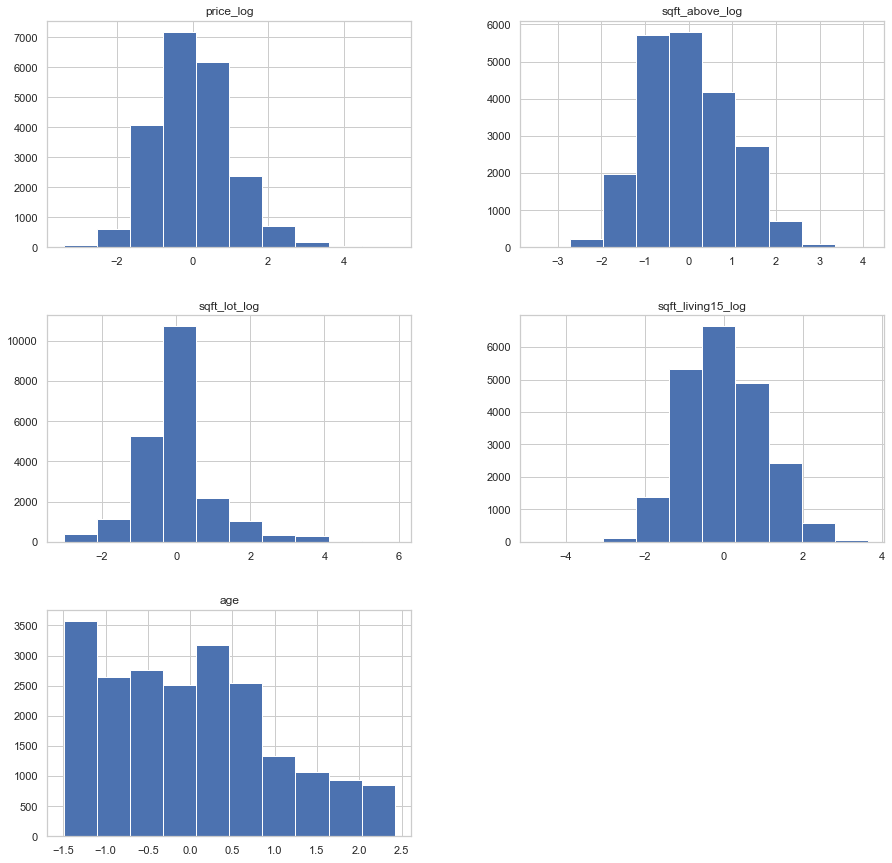

In [7]:
#plot the new normalized data
clean_continuous_norm.hist(figsize = (15, 15));

#save
plt.savefig('./Data & Figures/log_norm_histplot')

In [8]:
#drop previous values
clean.drop(['price_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot_log', 'age'], axis = 1, inplace = True)

In [9]:
#add the newly standardized values
clean = pd.concat([clean, clean_continuous_norm], axis = 1) 

In [10]:
#review
clean.head()

price  sqft_above  sqft_lot  sqft_living15  sqft_lot15  bedrooms  \
15937  268950.0         880      8100           1000        8100         3   
20963  399900.0         900      1005           1440        1188         2   
7614   339000.0         720      4128           1510        4538         3   
3257   380000.0         840      7372           1930        5150         2   
16723  365000.0        1600      4168           1190        4168         5   

       bathrooms  floors  water_1.0  base_1.0  ...  zip_E  zip_F  zip_G  \
15937       1.00     1.0          0         1  ...      1      0      0   
20963       1.75     1.5          0         1  ...      0      0      1   
7614        1.00     1.0          0         1  ...      0      0      0   
3257        1.00     1.0          0         1  ...      0      0      0   
16723       2.00     1.5          0         0  ...      0      0      0   

       zip_H  zip_I  price_log  sqft_above_log  sqft_lot_log  \
15937      0      0  -1.044412       -1.443346      0.011001   
20963      0      0  -0.288860       -1.390746     -2.297864   
7614       0      0  -0.603535       -1.913036     -0.734773   
3257       0      0  -0.386080       -1.552231     -0.093192   
16723      0      0  -0.462787       -0.044048     -0.724104   

       sqft_living15_log       age  
15937          -1.932101  0.955962  
20963          -0.818484 -1.357975  
7614           -0.673521  0.989991  
3257            0.075960  1.092076  
16723          -1.400849  1.500418  

[5 rows x 28 columns]

In [11]:
#review
clean.columns

Index(['price', 'sqft_above', 'sqft_lot', 'sqft_living15', 'sqft_lot15',
       'bedrooms', 'bathrooms', 'floors', 'water_1.0', 'base_1.0', 'reno_1.0',
       'cond_2.0', 'cond_3.0', 'cond_5.0', 'zip_A', 'zip_B', 'zip_C', 'zip_D',
       'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I', 'price_log',
       'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age'],
      dtype='object')

# MODEL 1: 
## LOG TRANSFORM ALL CONTINUOUS FEATURES
## WITHOUT LOCATION FEATURES

In [12]:
#including all log-transformed standardized features without neighborhood information
preprocessed_log_1 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age', 
                            'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0']]

#review
preprocessed_log_1.head(2)

price_log  sqft_above_log  sqft_lot_log  sqft_living15_log       age  \
15937  -1.044412       -1.443346      0.011001          -1.932101  0.955962   
20963  -0.288860       -1.390746     -2.297864          -0.818484 -1.357975   

       bedrooms  bathrooms  floors  water_1.0  base_1.0  reno_1.0  cond_2.0  \
15937         3       1.00     1.0          0         1         0         0   
20963         2       1.75     1.5          0         1         0         0   

       cond_3.0  cond_5.0  
15937         1         0  
20963         1         0

In [13]:
preprocessed_log_1.shape

(21420, 14)

In [14]:
#drop p-value > 0.05
#preprocessed_log_1.drop('age', axis = 1, inplace = True)

In [15]:
#specify X_train and y_train
X = preprocessed_log_1.drop(['price_log'], axis = 1)
y = preprocessed_log_1['price_log']

## Perform Stepwise Selection

In [16]:
#perform stepwise selection to ensure that we do not include any features with p-values of above 0.05 (learn.co)
def stepwise_selection(X, y, 
                       initial_list = [], 
                       threshold_in = 0.01, 
                       threshold_out = 0.05, 
                       verbose = True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.remove(worst_feature_name)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

In [17]:
#apply function
result_1 = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_1)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  sqft_above_log                 with p-value 4.91919e-208
Add  base_1.0                       with p-value 8.59585e-270
Add  floors                         with p-value 1.6827e-143
Add  water_1.0                      with p-value 1.82323e-102
Add  bedrooms                       with p-value 6.45593e-80
Add  sqft_lot_log                   with p-value 2.3291e-65
Add  cond_5.0                       with p-value 9.47873e-21
Add  cond_2.0                       with p-value 2.47298e-16
Add  reno_1.0                       with p-value 0.0020841
Add  cond_3.0                       with p-value 0.000490444
Resulting Features:
['bathrooms', 'age', 'sqft_living15_log', 'sqft_above_log', 'base_1.0', 'floors', 'water_1.0', 'bedrooms', 'sqft_lot_log', 'cond_5.0', 'cond_2.0', 'reno_1.0', 'cond_3.0']


In [18]:
#check out how many features satisfy p < 0.05
len(result_1)

13

## Build Model 1

In [19]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_1]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_1 = sm.OLS(y, X_intercept).fit() 

#get summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2309.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:04:58   Log-Likelihood:                -21008.
No. Observations:               21420   AIC:                         4.204e+04
Df Residuals:                   21406   BIC:                         4.216e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5127      0.032    -16.074      0.000      -0.575      -0.450
bathrooms             0.2348      0.010     22.888      0.000       0.215       0.255
age                   0.2908      0.006     47.429      0.000       0.279       0.303
sqft_living15_log     0.3055      0.007     44.513      0.000       0.292       0.319
sqft_above_log        0.4650      0.010     47.230      0.000       0.446       0.484
base_1.0              0.4944      0.012     42.524      0.000       0.472       0.517
floors                0.1664      0.012     13.370      0.000       0.142       0.191
water_1.0             1.1534      0.054     21.273      0.000       1.047       1.260
bedrooms             -0.1250      0.006    -19.727      0.000      -0.137      -0.113
sqft_lot_log         -0.0940      0.006    -16.841      0.000      -0.105      -0.083
cond_5.0              0.1380      0.018      7.596      0.000       0.102       0.174
cond_2.0             -0.4387      0.052     -8.503      0.000      -0.540      -0.338
reno_1.0              0.0896      0.026      3.507      0.000       0.040       0.140
cond_3.0             -0.0386      0.011     -3.486      0.000      -0.060      -0.017
==============================================================================
Omnibus:                       10.212   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.186
Skew:                           0.000   Prob(JB):                      0.00372
Kurtosis:                       3.112   Cond. No.                         56.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value rounds to 0 which rejects H0 of normality.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is <3, which indicates we do not have heavier tails. Our error is mesokuric. 
* The skewness value of 0 shows that underlying error is symmetrical. 

In [20]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_1], y)

#predict yhat using our model
yhat = linreg.predict(X[result_1])
yhat

array([-1.01506399, -0.7220789 , -0.73042222, ..., -0.46449712,
        0.10219922,  0.02776517])

In [21]:
#get intercept
linreg.intercept_

-0.5127101416607606

The slope is -0.51, which means there are some features that can negatively impact the price.

In [22]:
#get coefficients and sort them
coefficients_1 = dict(zip(X[result_1], list(linreg.coef_)))
dict(sorted(coefficients_1.items(), key = lambda item: item[1]))

{'cond_2.0': -0.43867684663917517,
 'bedrooms': -0.12495688399490304,
 'sqft_lot_log': -0.09399042723439216,
 'cond_3.0': -0.03859435957635661,
 'reno_1.0': 0.08957564206814088,
 'cond_5.0': 0.1380327401178583,
 'floors': 0.1663878873697879,
 'bathrooms': 0.23479435399219237,
 'age': 0.29081395843114566,
 'sqft_living15_log': 0.3054837585185844,
 'sqft_above_log': 0.4650298752113887,
 'base_1.0': 0.4943802593731762,
 'water_1.0': 1.1534400283879975}

In [23]:
!pip install waterfallcharts
!pip install plotly==4.14.3
import waterfall_chart
import plotly.graph_objects as go

In [24]:
lists_1 = sorted(coefficients_1.items(), key = lambda item: item[1])
a, b = zip(*lists_1)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model 1 Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_1_waterfall.png')

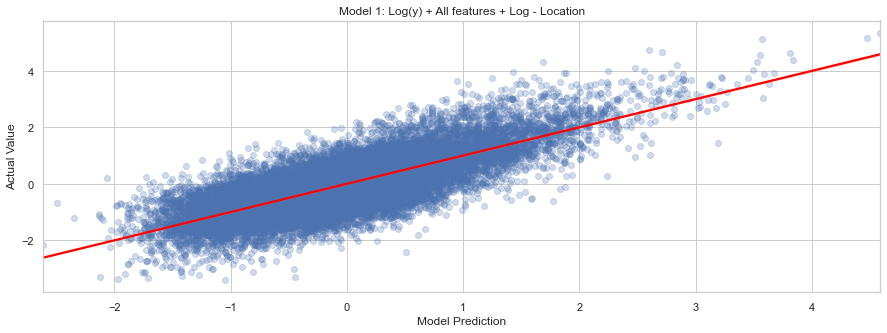

In [25]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25})
plt.title('Model 1: Log(y) + All features + Log - Location')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_1_scatterplot')

## Rank Features for Model 1

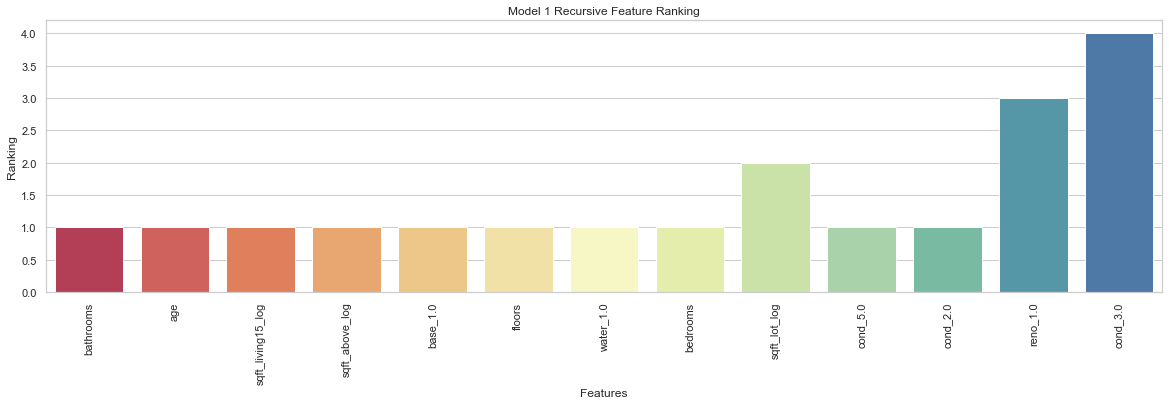

<Figure size 432x288 with 0 Axes>

In [26]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_1], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_1].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model 1 Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_1_recursive_features_elimination')

## Test Model 1

**Recheck for multicollinearity**

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables (features X) within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

VIF quantifies how much the variance is inflated.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_1].values, i) for i in range(X[result_1].shape[1])] 
list(zip(result_1, vif))

[('bathrooms', 23.727457948474726),
 ('age', 1.790770894754111),
 ('sqft_living15_log', 2.420880383094319),
 ('sqft_above_log', 3.0604690655923914),
 ('base_1.0', 2.647755566628498),
 ('floors', 14.353688084287965),
 ('water_1.0', 1.030213928249951),
 ('bedrooms', 16.570973396111665),
 ('sqft_lot_log', 1.4146442596012243),
 ('cond_5.0', 1.3336727899987602),
 ('cond_2.0', 1.0336038147780997),
 ('reno_1.0', 1.1525935915616632),
 ('cond_3.0', 3.8930254894975067)]

While the p-values indicate that all of the current features are impactful, the variance inflation factor indicates that there is moderate multicollinearity between our variables.  A rule of thumb commonly used in practice is if a VIF is > 10, we have high multicollinearity, and the parameter estimates will have large standard errors because of this. We see here those 'problematic' features are:

* 'bathrooms', 23.727457948474726
* 'bedrooms', 16.570973396111693
* 'floors', 14.353688084287965

Let's recheck for multicollinearity.

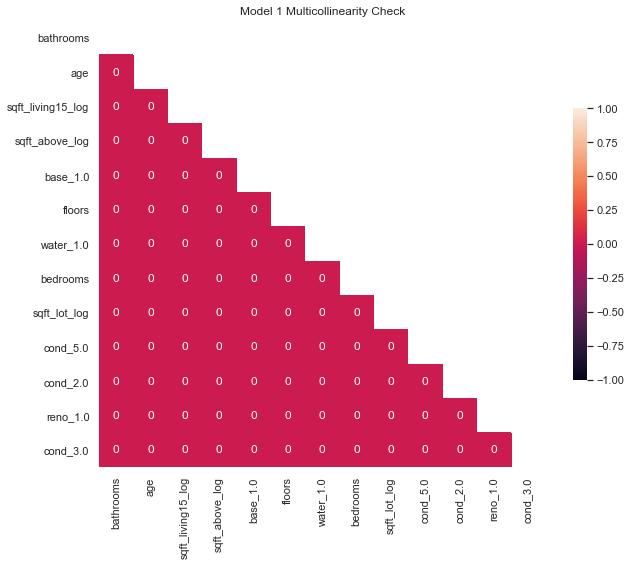

In [28]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_1].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_1].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model 1 Multicollinearity Check')
plt.savefig('./Data & Figures/model_1_multicollinearity_check')

None of the features are highly correlated. We can safely move on.

**Recheck for normality**

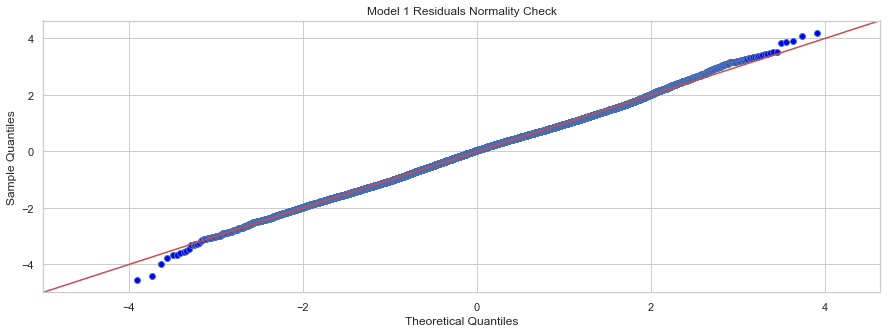

<Figure size 432x288 with 0 Axes>

In [29]:
#recheck for normality
fig = sm.graphics.qqplot(model_1.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model 1 Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_qqplot')

Assumption of residual normality is satisfied.

**Recheck for homoscedasticity**

Goldfeld-Quandt test examines whether the residual variance is the same in 2 subsamples.

In [30]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_1.resid, model_1.model.exog)
list(zip(name, test))

[('F statistic', 1.0697320299524764), ('p-value', 0.0002457789986660285)]

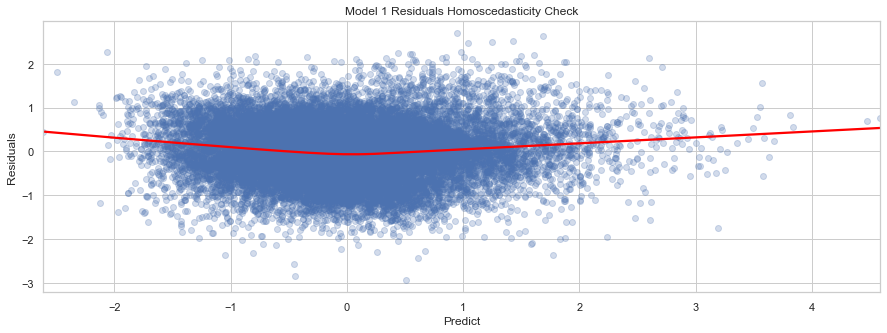

<Figure size 432x288 with 0 Axes>

In [31]:
#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_1.predict(), 
            y = model_1.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
           scatter_kws = {'color':'b','alpha': 0.25})
plt.title('Model 1 Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_1_homoscedasticity_regplot')

The shape of residual is a symmetrical 'blob', meaning homoscedastic data is evenly dispersed around the regression line. Assumption of residual homoscedasticity is satisfied.

**Recheck for overfitting: K-Fold Cross Validation**

In order to deal with the issues that random sampling can introduce into interpreting the quality of our models, we'll use a more advanced technique called K-Fold Cross Validation. The downside of the train test split is that every time we do a split we obtain a slighlty different result. That's where doing Cross-Validation has a big advantage because with it we're doing a multiple split test and getting the average value from it.

K-Fold Cross Validation expands on the idea of training and test splits by splitting the entire dataset into {K} equal sections of data. We'll then iteratively train {K} linear regression models on the data, with each linear model using a different section of data as the test set, and all other sections combined as the training set.

We can then average the individual results frome each of these linear models to get a Cross-Validation MSE. This will be closer to the model's actual MSE, since "noisy" results that are higher than average will cancel out the "noisy" results that are lower than average.

In [32]:
#cross-validation to check for overfitting
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#cross-validation to check for overfitting
linreg = LinearRegression()

#the accuracy of the model is the average of the accuracy of each fold
cv_result = cross_val_score(linreg, X[result_1], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

-0.6467113295317628


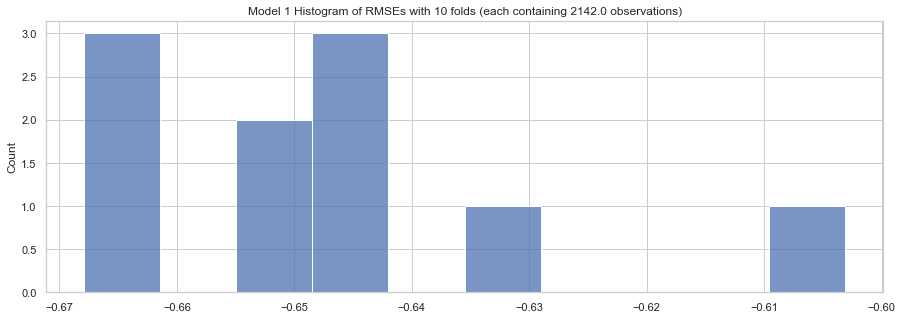

In [33]:
#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model 1 Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_1) / folds, 0)));
plt.savefig('./Data & Figures/model_1_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model 1

In order to get a good sense of how well our model will be doing on new instances, we'll have to perform a so-called "train-test-split". What we'll be doing here, is take a sample of the data that serves as input to "train" our model - fit a linear regression and compute the parameter estimates for our variables, and calculate how well our predictive performance is doing comparing the actual targets y and the fitted yhat obtained by our model.

* Underfitting happens when a model cannot learn the training data, nor can it generalize to new data.
* Overfitting happens when a model learns the training data too well. In fact, so well that it is not generalizeable to new data

In [34]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[result_1], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

17136 17136 4284 4284


In [35]:
#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

To evaluate the model, we compare our predicted values, yhat with the actual value 𝑦 . The difference between the two values is referred to as the residuals. We'll compare our residuals for both test set and training set. To get a summarized measure over all the instances in the test set and training set, a popular metric is the RME (Root Mean Squared Error). A big difference in value between the test and training set (R)MSE is an indication of overfitting.

In [36]:
#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

In [37]:
#calculate training and test RMSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

0.6466107231291456
0.6398193484246292


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

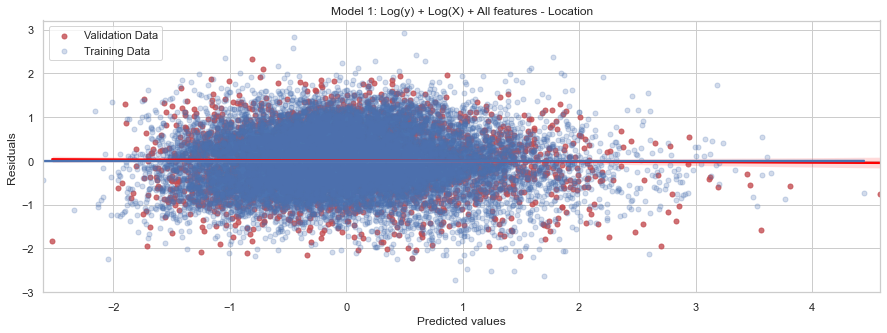

<Figure size 432x288 with 0 Axes>

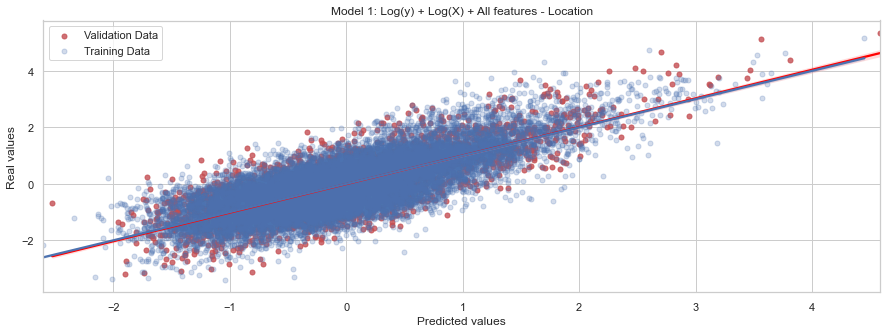

<Figure size 432x288 with 0 Axes>

In [38]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model 1: Log(y) + Log(X) + All features - Location')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_1_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model 1: Log(y) + Log(X) + All features - Location')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_1_predictions_regplot')

In [39]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 60%'

**Bias-Variance Tradeoff**

* Bias arises when wrong assumptions are made when training a model. For example, an interaction effect is missed, or we didn't catch a certain polynomial relationship. Because of this, our algorithm misses the relevant relations between predictors and the target variable. Note how this is similar to underfitting!

* Variance arises when a model is too sensitive to small fluctuations in the training set. When variance is high, random noise in the training data is modeled, rather than the intended outputs. This is overfitting!

The balance between bias and variance is a trade-off. We can reduce the variance but then there is a risk of running a bigger bias, and vice versa. Bias is usually associated with low model complexity, variance with high model complexity. There is generally a "sweet spot" in-between, compromising between bias and variance.

In [40]:
#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Scale the train set
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set
X_test_scaled = scaler.transform(X_test)

In [41]:
#fit the model to train data
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

#test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

In [42]:
#function bias() to calculate the bias of a model's predictions given the actual data
def bias(y, y_hat):
    return np.mean(y_hat - y)

#function variance() to calculate the variance of a model's predictions
def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

In [43]:
#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

Train bias: 3.040414688352553e-16 
Train variance: 0.5781577193413546


In [44]:
#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Test bias: 0.00911038433601995 
Test variance: 0.5913110018000968


In [45]:
import pickle

#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_1.pkl','wb'))

In [46]:
summary_table_2 = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [], 
                                'r2': [], 'Accuracy':[], 
                                'RMSE Train': [], 'RMSE Test': [],
                                'Bias Train': [], 'Bias Test': [], 'Variance Train': [], 'Variance Test': [],
                                'Cross Validation': [],
                                'Multicollinearity': [], 'Normality': [], 'Homoscedasticity': []})

summary_table_2.loc[0] = ['Model 1', 'Log(y) + Log(X) + All features - location', len(result_1), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_2.head()

Model                                Description   Num Features  \
0  Model 1  Log(y) + Log(X) + All features - location           13.0   

         r2   Accuracy  RMSE Train  RMSE Test    Bias Train  Bias Test  \
0  0.583683  59.656684    0.646611   0.639819  3.040415e-16    0.00911   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.578158       0.591311         -0.646711                 P   

  Normality Homoscedasticity  
0         P                P

# MODEL 2
## USING LOCATION FEATURES

In [47]:
preprocessed_log_2 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log',
                            'age', 'bedrooms', 'bathrooms', 'floors',
                            'water_1.0', 'base_1.0', 'reno_1.0',
                            'cond_2.0', 'cond_3.0', 'cond_5.0',
                            'zip_A', 'zip_B', 'zip_C', 'zip_E', 'zip_D', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

preprocessed_log_2.head()

price_log  sqft_above_log  sqft_lot_log  sqft_living15_log       age  \
15937  -1.044412       -1.443346      0.011001          -1.932101  0.955962   
20963  -0.288860       -1.390746     -2.297864          -0.818484 -1.357975   
7614   -0.603535       -1.913036     -0.734773          -0.673521  0.989991   
3257   -0.386080       -1.552231     -0.093192           0.075960  1.092076   
16723  -0.462787       -0.044048     -0.724104          -1.400849  1.500418   

       bedrooms  bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  \
15937         3       1.00     1.0          0         1  ...         0      0   
20963         2       1.75     1.5          0         1  ...         0      0   
7614          3       1.00     1.0          0         1  ...         0      1   
3257          2       1.00     1.0          0         1  ...         1      1   
16723         5       2.00     1.5          0         0  ...         0      1   

       zip_B  zip_C  zip_E  zip_D  zip_F  zip_G  zip_H  zip_I  
15937      0      0      1      0      0      0      0      0  
20963      0      0      0      0      0      1      0      0  
7614       0      0      0      0      0      0      0      0  
3257       0      0      0      0      0      0      0      0  
16723      0      0      0      0      0      0      0      0  

[5 rows x 23 columns]

In [48]:
preprocessed_log_2.shape

(21420, 23)

In [49]:
#drop p > 0.05
#preprocessed_log_2.drop(['sqft_above_log'], axis = 1, inplace = True)

In [50]:
#drop p > 0.05
#preprocessed_log_2.drop(['zip_B'], axis = 1, inplace = True)

In [51]:
#define X, y 
X = preprocessed_log_2.drop(['price_log'], axis=1)
y = preprocessed_log_2['price_log']

In [52]:
#apply stepwise function
result_2 = stepwise_selection(X, y, verbose = True)
print('Resulting Features:')
print(result_2)

Add  bathrooms                      with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  zip_E                          with p-value 3.66198e-291
Add  base_1.0                       with p-value 4.97012e-275
Add  water_1.0                      with p-value 1.60382e-237
Add  zip_C                          with p-value 5.30479e-77
Add  bedrooms                       with p-value 1.55017e-61
Add  zip_I                          with p-value 4.31229e-53
Add  cond_3.0                       with p-value 4.64391e-34
Add  cond_2.0                       with p-value 1.01166e-26
Add  reno_1.0                       with p-value 4.43162e-17
Add  zip_B              

In [53]:
#check out how many features satisfy p < 0.05
len(result_2)

21

## Build Model 2

In [54]:
#build model in statsmodels
import statsmodels.api as sm

#interecept is not included by default and should be added manually
X_in = X[result_2]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_2 = sm.OLS(y, X_intercept).fit() 

#get summary
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     3287.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:05:26   Log-Likelihood:                -14957.
No. Observations:               21420   AIC:                         2.996e+04
Df Residuals:                   21398   BIC:                         3.013e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.4820      0.031    -15.399      0.000      -0.543      -0.421
bathrooms             0.1881      0.008     24.275      0.000       0.173       0.203
age                   0.1082      0.005     20.448      0.000       0.098       0.119
sqft_living15_log     0.2414      0.005     45.271      0.000       0.231       0.252
zip_D                -0.4800      0.024    -20.355      0.000      -0.526      -0.434
zip_H                -0.4829      0.024    -20.401      0.000      -0.529      -0.437
zip_A                 0.6358      0.022     28.575      0.000       0.592       0.679
zip_F                -0.6785      0.023    -29.041      0.000      -0.724      -0.633
sqft_above_log        0.4511      0.007     60.702      0.000       0.437       0.466
zip_E                -0.2871      0.024    -11.779      0.000      -0.335      -0.239
base_1.0              0.3381      0.009     37.453      0.000       0.320       0.356
water_1.0             1.3026      0.041     31.689      0.000       1.222       1.383
zip_C                 0.5197      0.022     23.139      0.000       0.476       0.564
bedrooms             -0.0818      0.005    -16.997      0.000      -0.091      -0.072
cond_3.0             -0.0933      0.009    -10.966      0.000      -0.110      -0.077
cond_2.0             -0.4061      0.039    -10.430      0.000      -0.482      -0.330
reno_1.0              0.1674      0.019      8.659      0.000       0.129       0.205
zip_B                 0.3749      0.022     17.089      0.000       0.332       0.418
zip_G                 0.2603      0.023     11.347      0.000       0.215       0.305
cond_5.0              0.1019      0.014      7.423      0.000       0.075       0.129
sqft_lot_log          0.0334      0.005      7.420      0.000       0.025       0.042
floors                0.0359      0.010      3.706      0.000       0.017       0.055
==============================================================================
Omnibus:                      527.330   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1267.609
Skew:                          -0.011   Prob(JB):                    5.52e-276
Kurtosis:                       4.192   Cond. No.                         85.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With location features included, our r2 increases to 0.723, meaning our Model 2 performs better than our Model 1 (r2 = 0.6, without location features).

* p-value of 0 which rejects H0.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is >3, which indicates we might have slightly heavy tail. Our error is leptokuric. 
* The skewness value of -0.022 shows that underlying error is symmetrical. 

In [55]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X[result_2], y)

#predict yhat using our model
yhat = linreg.predict(X[result_2])
yhat

array([-1.55952772, -0.80615666, -0.47263528, ..., -0.73672965,
       -0.38534675, -0.70150628])

In [56]:
#get intercept
linreg.intercept_

-0.48202641978435523

In [57]:
#get coefficients and sort them
coefficients_2 = dict(zip(X[result_2], list(linreg.coef_)))
dict(sorted(coefficients_2.items(), key = lambda item: item[1]))

{'zip_F': -0.6785318364049527,
 'zip_H': -0.48293471494698953,
 'zip_D': -0.4799555901040271,
 'cond_2.0': -0.40609872474390957,
 'zip_E': -0.2871390398698956,
 'cond_3.0': -0.09330270271820247,
 'bedrooms': -0.08181230260201645,
 'sqft_lot_log': 0.033398198437863374,
 'floors': 0.03586352280938448,
 'cond_5.0': 0.10187251381002801,
 'age': 0.10817911084572235,
 'reno_1.0': 0.1673602878781918,
 'bathrooms': 0.18812281275940304,
 'sqft_living15_log': 0.24135895483008205,
 'zip_G': 0.26031618412102697,
 'base_1.0': 0.33808269624294185,
 'zip_B': 0.37485627792093873,
 'sqft_above_log': 0.4511352903819297,
 'zip_C': 0.5197459732399875,
 'zip_A': 0.6358012627975019,
 'water_1.0': 1.3025589324012683}

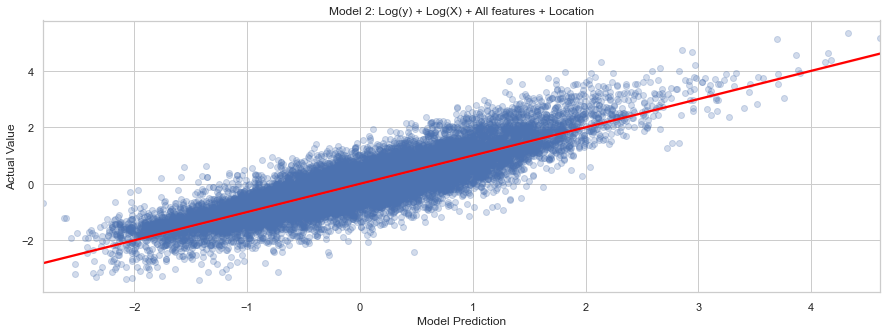

In [58]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25})
plt.title('Model 2: Log(y) + Log(X) + All features + Location')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_2_scatterplot')

## Rank Features for Model 2

In [59]:
lists_2 = sorted(coefficients_2.items(), key = lambda item: item[1])
a, b = zip(*lists_2)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model 2 Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_2_waterfall.png')

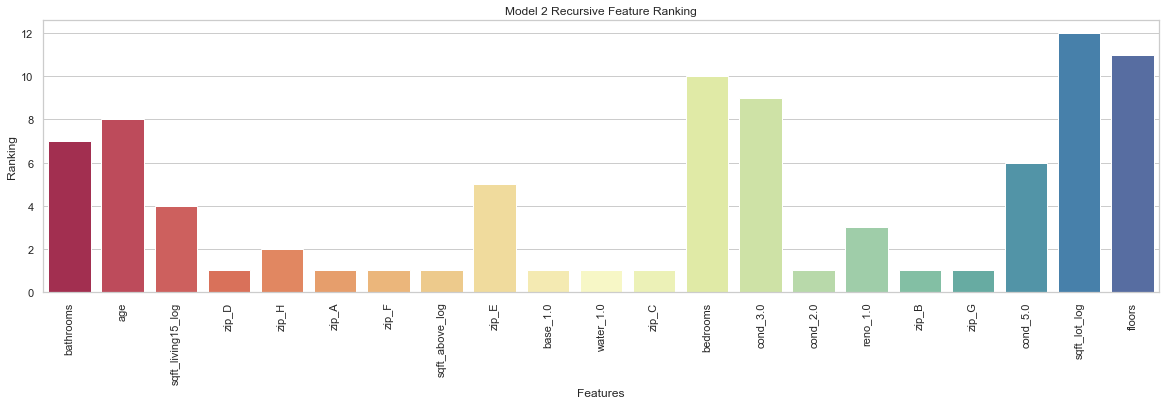

<Figure size 432x288 with 0 Axes>

In [60]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X[result_2], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X[result_2].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model 2 Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_2_recursive_features_elimination')

## Test Model 2

**Recheck for multicollinearity, normality, homoscedasticity**

In [61]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[result_2].values, i) for i in range(X[result_2].shape[1])] 
list(zip(result_2, vif))

[('bathrooms', 25.331150279970043),
 ('age', 2.453391951092251),
 ('sqft_living15_log', 2.5703520992183133),
 ('zip_D', 2.6417754496267536),
 ('zip_H', 2.4420862098077927),
 ('zip_A', 10.48069802354823),
 ('zip_F', 2.616932359711573),
 ('sqft_above_log', 3.872650368898485),
 ('zip_E', 2.463808780215732),
 ('base_1.0', 2.840759902120135),
 ('water_1.0', 1.0414200817648878),
 ('zip_C', 3.5839686623370173),
 ('bedrooms', 20.953465620569055),
 ('cond_3.0', 4.071285238783209),
 ('cond_2.0', 1.0354553600796004),
 ('reno_1.0', 1.162750887937444),
 ('zip_B', 3.75633132133634),
 ('zip_G', 2.852807561401125),
 ('cond_5.0', 1.3387742894357293),
 ('sqft_lot_log', 1.6757585896516245),
 ('floors', 17.493787067989974)]

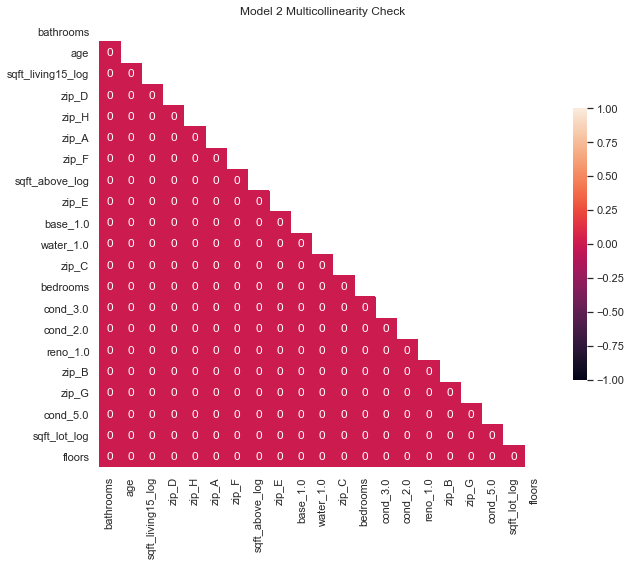

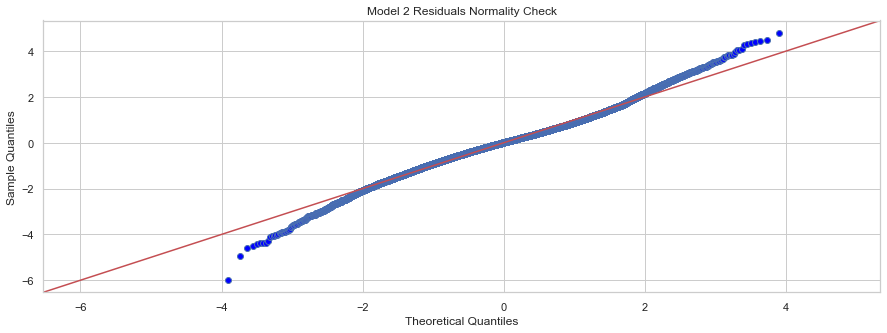

<Figure size 432x288 with 0 Axes>

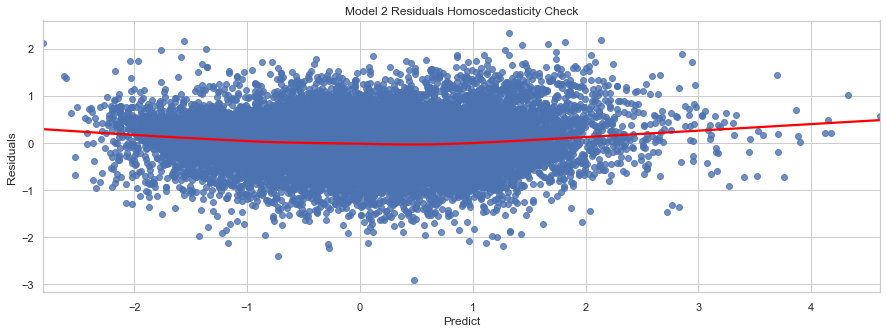

<Figure size 432x288 with 0 Axes>

In [62]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[result_2].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[result_2].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)    
    plt.title('Model 2 Multicollinearity Check')
plt.savefig('./Data & Figures/model_2_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_2.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model 2 Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_2.predict(), 
            y = model_2.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model 2 Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_2_homoscedasticity_regplot')

In [63]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_2.resid, model_2.model.exog)
list(zip(name, test))

[('F statistic', 1.0788622044037743), ('p-value', 4.369492129972441e-05)]

In [64]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[result_2], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

-0.4887252849455388


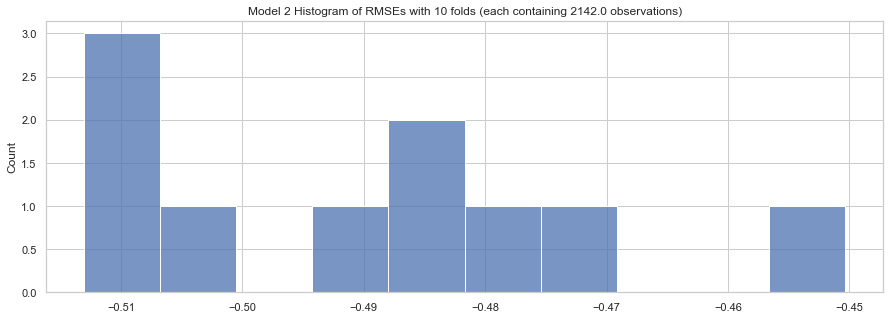

In [65]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model 2 Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_2) / folds, 0)));
plt.savefig('./Data & Figures/model_2_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model 2

In [66]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[result_2], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.487978559154872
0.480466165641546


Our (R)MSE of train set and test set are quite similar, we  did not overfit the model.

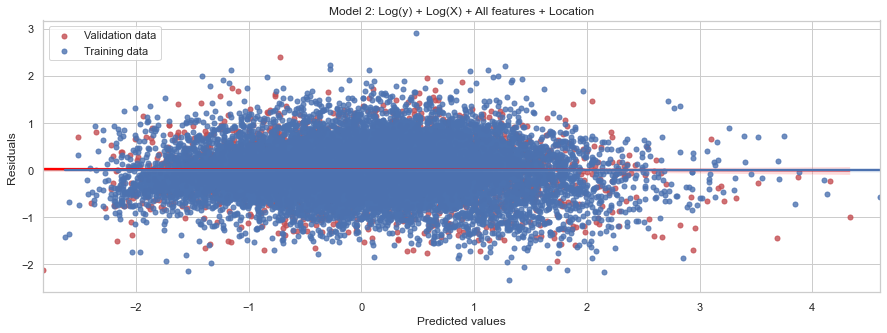

<Figure size 432x288 with 0 Axes>

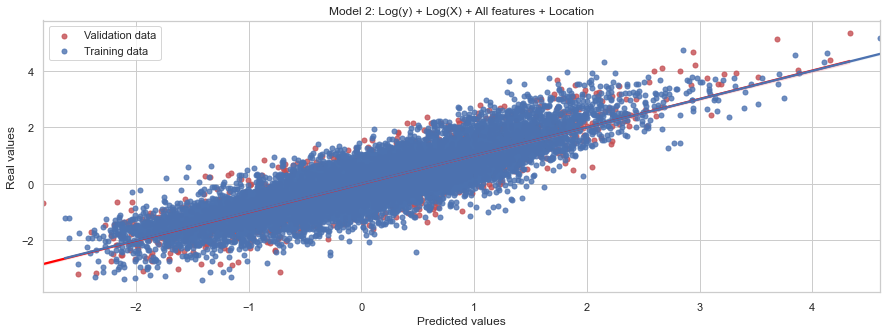

<Figure size 432x288 with 0 Axes>

In [67]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {"s": 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_hat_train - y_train, 
                scatter_kws = {"s": 25}, 
            fit_reg = True, label = "Training data")

plt.title("Model 2: Log(y) + Log(X) + All features + Location")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_2_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            line_kws = {'color': 'red'},
            scatter_kws = {"s": 25}, 
            color = 'r',
            fit_reg = True, label = "Validation data")
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {"s": 25}, 
            fit_reg = True, label = "Training data")

plt.title("Model 2: Log(y) + Log(X) + All features + Location")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_2_predictions_regplot')

In [68]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [69]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.2501444540518836 
Train variance: 0.31946788072047755
Test bias: 0.25340373302649716 
Test variance: 0.31271433229954176


In [70]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_2.pkl','wb'))

In [71]:
summary_table_2.loc[1] = ['Model 2', 'Log(y) + Log(X) + All features + location', len(result_2), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_2.head()

Model                                Description   Num Features  \
0  Model 1  Log(y) + Log(X) + All features - location           13.0   
1  Model 2  Log(y) + Log(X) + All features + location           21.0   

         r2   Accuracy  RMSE Train  RMSE Test    Bias Train  Bias Test  \
0  0.583683  59.656684    0.646611   0.639819  3.040415e-16   0.009110   
1  0.763374  77.249944    0.487979   0.480466  2.501445e-01   0.253404   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.578158       0.591311         -0.646711                 P   
1        0.319468       0.312714         -0.488725                 P   

  Normality Homoscedasticity  
0         P                P  
1         P                P

# MODEL 3
## RECURSIVE FEATURE RANKING

RFE is effective at selecting those features in a training dataset that are more or most relevant in predicting the target variable.

RFE assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [72]:
#fit the linear regression model again using the selected columns
selected_features = X[result_2].columns[selector.support_ ]

linreg.fit(X[selected_features], y)

LinearRegression()

In [73]:
#get coefficients and sort them
coefficients = dict(zip(X[selected_features], list(linreg.coef_)))
dict(sorted(coefficients.items(), key = lambda item: item[1]))

{'zip_F': -0.38245879904594443,
 'cond_2.0': -0.30574074191872547,
 'zip_D': -0.16932579204389223,
 'base_1.0': 0.5274948025066557,
 'zip_G': 0.6425307981773931,
 'sqft_above_log': 0.6589109583781005,
 'zip_B': 0.7431126832591902,
 'zip_C': 0.9511587275160359,
 'zip_A': 0.9743659615567494,
 'water_1.0': 1.5601682879133765}

**Features that decrease value of a home:**

* 'zip_F': -1.2548922218727825,
* 'zip_D': -1.0491366252610925,
* 'zip_H': -1.0187389131494606,
* 'zip_E': -0.8844244243478455,
* 'zip_I': -0.5182728438177658,
* 'cond_2.0': -0.3207594093265525,

 **Features that increase value of a home:**
 
* 'reno_1.0': 0.2904992266135896,
* 'base_1.0': 0.5453731324173593,
* 'sqft_above_log': 0.6254666820172676,
* 'water_1.0': 1.5269140497447495

## Build Model 3

In [74]:
#build model in statsmodels

#interecept is not included by default and should be added manually
X_in = X[selected_features]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_3 = sm.OLS(y, X_intercept).fit() 

#get summary
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     5323.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:05:48   Log-Likelihood:                -17018.
No. Observations:               21420   AIC:                         3.406e+04
Df Residuals:                   21409   BIC:                         3.415e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7787      0.009    -83.179      0.000      -0.797      -0.760
zip_D             -0.1693      0.016    -10.462      0.000      -0.201      -0.138
zip_A              0.9744      0.011     85.226      0.000       0.952       0.997
zip_F             -0.3825      0.016    -23.939      0.000      -0.414      -0.351
sqft_above_log     0.6589      0.004    162.852      0.000       0.651       0.667
base_1.0           0.5275      0.008     67.038      0.000       0.512       0.543
water_1.0          1.5602      0.045     34.911      0.000       1.473       1.648
zip_C              0.9512      0.014     67.359      0.000       0.923       0.979
cond_2.0          -0.3057      0.042     -7.215      0.000      -0.389      -0.223
zip_B              0.7431      0.014     54.531      0.000       0.716       0.770
zip_G              0.6425      0.016     40.944      0.000       0.612       0.673
==============================================================================
Omnibus:                      428.837   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.044
Skew:                           0.088   Prob(JB):                    2.16e-191
Kurtosis:                       3.976   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With recursive feature ranking selecting 10 best features, our r2 decreases to 0.72, our Model 2 performs worse than our Model 2 (r2 = 0.77).

72% of the dataset variation from the mean can be explained by our Model 3.

* p-value of 0 which rejects H0 of normality.
* All of the features p-values indicate that all of the current features are substantially influential.
* Kurtosis is >3, which indicates we might have slightly heavy tail. Our error is leptokuric. 
* The skewness value of ~0 shows that underlying error is symmetrical. 

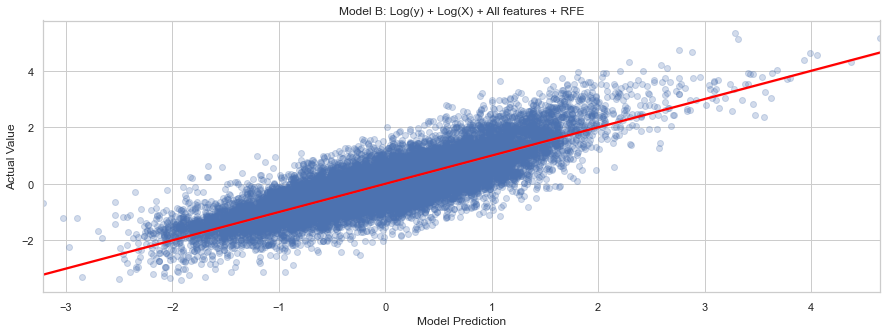

In [75]:
#predict yhat using our model
yhat = linreg.predict(X[selected_features])
yhat

#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha':0.25},color='r')
plt.title('Model B: Log(y) + Log(X) + All features + RFE')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_3_regplot')

## Test Model 3

In [76]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X[selected_features].values, i) for i in range(X[selected_features].shape[1])] 
list(zip(selected_features, vif))

[('zip_D', 1.0383527497476681),
 ('zip_A', 1.4830016548397356),
 ('zip_F', 1.029927238960382),
 ('sqft_above_log', 1.219238119233498),
 ('base_1.0', 1.742387696421824),
 ('water_1.0', 1.0130006319641907),
 ('zip_C', 1.135139618365052),
 ('cond_2.0', 1.0098797588628976),
 ('zip_B', 1.099950327527982),
 ('zip_G', 1.083292200001457)]

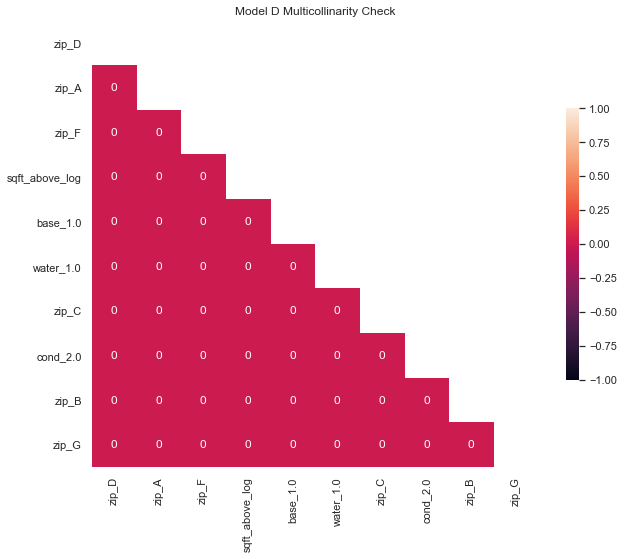

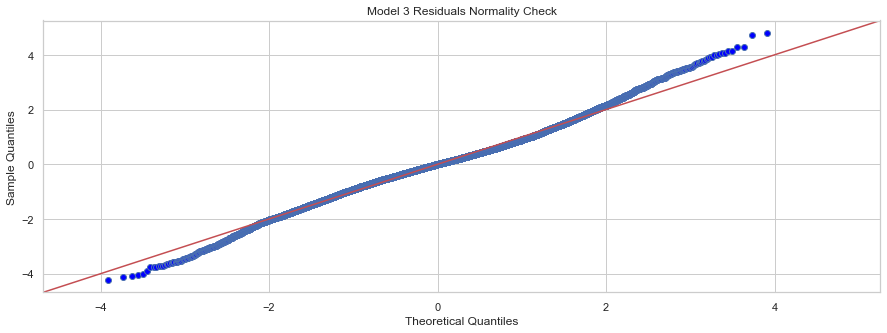

<Figure size 432x288 with 0 Axes>

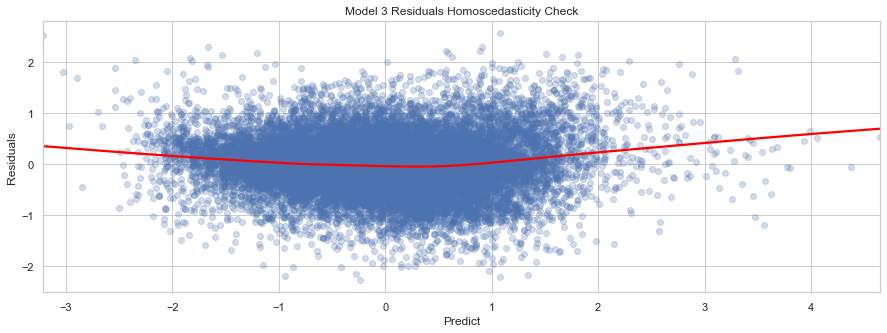

<Figure size 432x288 with 0 Axes>

In [77]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X[selected_features].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X[selected_features].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)
    plt.title('Model 3 Multicollinearity Check')
    plt.title('Model D Multicollinarity Check')
plt.savefig('./Data & Figures/model_3_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_3.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model 3 Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_3_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_3.predict(), 
            y = model_3.resid, 
            lowess = True, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25}, color = 'r')
plt.title('Model 3 Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_3_homoscedasticity_regplot')

In [78]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)

17136 17136 4284 4284
0.288547227070594
0.2800407632678754


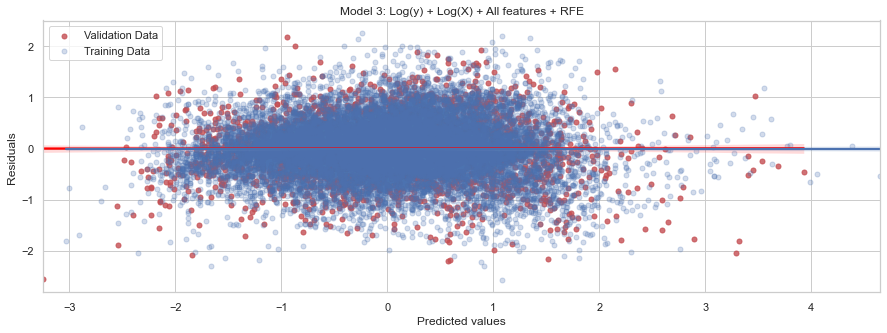

<Figure size 432x288 with 0 Axes>

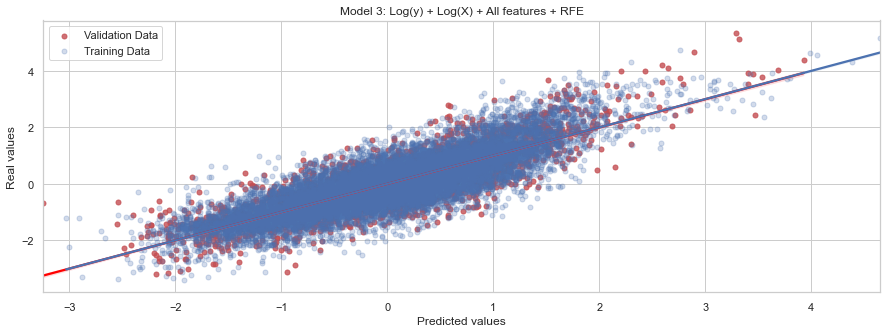

<Figure size 432x288 with 0 Axes>

In [79]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')

plt.title('Model 3: Log(y) + Log(X) + All features + RFE')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_3_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model 3: Log(y) + Log(X) + All features + RFE')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_3_predictions_regplot')

In [80]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_3.resid, model_3.model.exog)
list(zip(name, test))

[('F statistic', 1.053088981958748), ('p-value', 0.003735988726427595)]

In [81]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_mean_squared_error')
print(cv_result.mean())

-0.28873308214221904


In [82]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X[selected_features], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

-0.5369782534578451


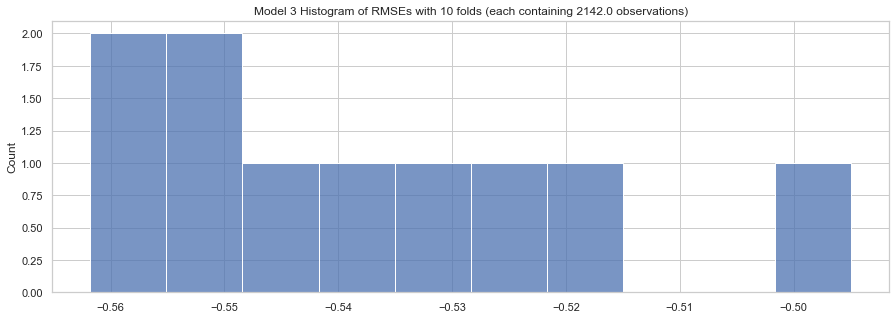

In [83]:
#visualize the cv_result
folds = 10
plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model 3 Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_2) / folds, 0)));
plt.savefig('./Data & Figures/model_3_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model 3

In [84]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test RMSE
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.5371659213600524
0.5291887784787914


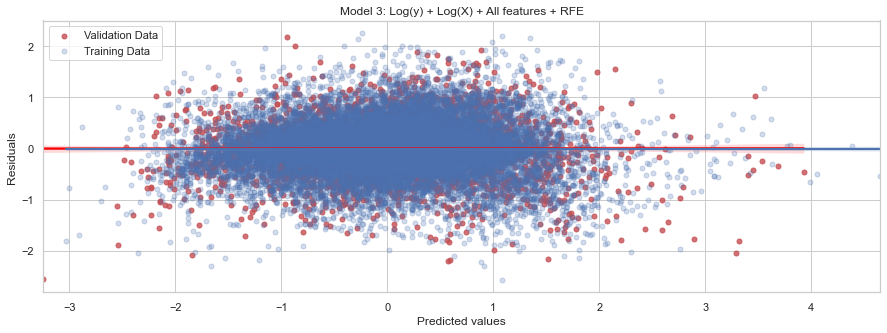

<Figure size 432x288 with 0 Axes>

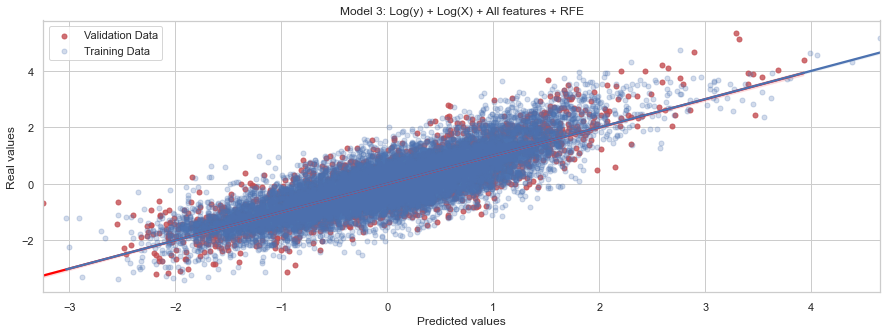

<Figure size 432x288 with 0 Axes>

In [85]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training Data')


plt.title('Model 3: Log(y) + Log(X) + All features + RFE')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_3_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'}, 
            color = 'r',
            fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, 
            fit_reg = True, label = 'Training Data')

plt.title('Model 3: Log(y) + Log(X) + All features + RFE')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_3_predictions_regplot')

In [86]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
'Accuracy: {}%'.format(int(round(accuracy * 100)))

'Accuracy: 72%'

In [87]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.29996193409897837 
Train variance: 0.3688610642978878
Test bias: 0.30284617076087844 
Test variance: 0.36359812006280134


In [88]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_3.pkl','wb'))

In [89]:
summary_table_2.loc[2] = ['Model 3', 'Log(y) + Log(X) + All features + RFE', len(selected_features), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_2.head()

Model                                Description   Num Features  \
0  Model 1  Log(y) + Log(X) + All features - location           13.0   
1  Model 2  Log(y) + Log(X) + All features + location           21.0   
2  Model 3       Log(y) + Log(X) + All features + RFE           10.0   

         r2   Accuracy  RMSE Train  RMSE Test    Bias Train  Bias Test  \
0  0.583683  59.656684    0.646611   0.639819  3.040415e-16   0.009110   
1  0.763374  77.249944    0.487979   0.480466  2.501445e-01   0.253404   
2  0.713161  72.401968    0.537166   0.529189  2.999619e-01   0.302846   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.578158       0.591311         -0.646711                 P   
1        0.319468       0.312714         -0.488725                 P   
2        0.368861       0.363598         -0.536978                 P   

  Normality Homoscedasticity  
0         P                P  
1         P                P  
2         P                P

# MODEL 4
## INTERACTIONS

### See how interactions improve our baseline

In [90]:
#create new dataframe
preprocessed_log_4 = clean[['price_log', 'sqft_above_log', 'sqft_lot_log', 'sqft_living15_log', 'age', 
                       'bedrooms', 'bathrooms', 'floors', 
                       'water_1.0', 'base_1.0', 'reno_1.0',
                       'cond_2.0', 'cond_3.0', 'cond_5.0', 
                       'zip_A', 'zip_B', 'zip_C', 'zip_D', 'zip_E', 'zip_F', 'zip_G', 'zip_H', 'zip_I']]

#review
preprocessed_log_4.head(2)

price_log  sqft_above_log  sqft_lot_log  sqft_living15_log       age  \
15937  -1.044412       -1.443346      0.011001          -1.932101  0.955962   
20963  -0.288860       -1.390746     -2.297864          -0.818484 -1.357975   

       bedrooms  bathrooms  floors  water_1.0  base_1.0  ...  cond_5.0  zip_A  \
15937         3       1.00     1.0          0         1  ...         0      0   
20963         2       1.75     1.5          0         1  ...         0      0   

       zip_B  zip_C  zip_D  zip_E  zip_F  zip_G  zip_H  zip_I  
15937      0      0      0      1      0      0      0      0  
20963      0      0      0      0      0      1      0      0  

[2 rows x 23 columns]

In [91]:
#define training variables
X = preprocessed_log_4.drop(['price_log'], axis = 1)
y = preprocessed_log_4['price_log']

In [92]:
#get baseline model r2
from sklearn.model_selection import KFold

linreg = LinearRegression()

crossvalidation = KFold(n_splits = 10, shuffle = True, random_state =1)

baseline = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossvalidation))
baseline

0.7624759217847974

Create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the  𝑅2 . We'll look at the 10 interactions which have the biggest effect on our  𝑅2 , so print out the top 10 combinations.

In [93]:
from itertools import combinations

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(linreg, data, y, scoring='r2', cv = crossvalidation))
    if score > baseline:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 10 interactions: %s' %sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10])

0
50
100
150
200
Top 10 interactions: [('sqft_living15_log', 'zip_C', 0.767), ('sqft_above_log', 'bathrooms', 0.766), ('sqft_lot_log', 'zip_A', 0.766), ('sqft_lot_log', 'zip_C', 0.765), ('sqft_above_log', 'sqft_lot_log', 0.764), ('sqft_above_log', 'sqft_living15_log', 0.764), ('sqft_above_log', 'zip_C', 0.764), ('sqft_lot_log', 'age', 0.764), ('sqft_lot_log', 'bathrooms', 0.764), ('sqft_lot_log', 'zip_H', 0.764)]


In [94]:
#check how many pairs of interaction there are
len(interactions)

127

In [95]:
sorted(interactions, key = lambda inter: inter[2], reverse = True)[:10]

[('sqft_living15_log', 'zip_C', 0.767),
 ('sqft_above_log', 'bathrooms', 0.766),
 ('sqft_lot_log', 'zip_A', 0.766),
 ('sqft_lot_log', 'zip_C', 0.765),
 ('sqft_above_log', 'sqft_lot_log', 0.764),
 ('sqft_above_log', 'sqft_living15_log', 0.764),
 ('sqft_above_log', 'zip_C', 0.764),
 ('sqft_lot_log', 'age', 0.764),
 ('sqft_lot_log', 'bathrooms', 0.764),
 ('sqft_lot_log', 'zip_H', 0.764)]

We can see that interactions happen a lot between zip area and square footage of a home, indicating that neighborhood is a big contributor to the value of a home.

In [96]:
#get price_log_med
preprocessed_log_4['price_log_med'] = preprocessed_log_4['price_log'] > preprocessed_log_4['price_log'].median()
preprocessed_log_4['price_log_med'] = np.where(preprocessed_log_4['price_log_med'] == False, 'Below Median', 'Above Median')

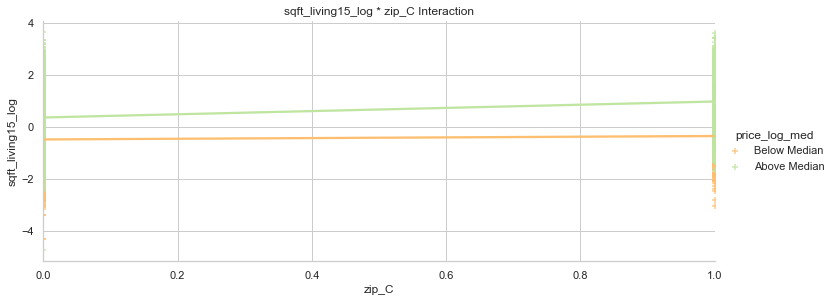

In [97]:
#plot sqft_living15_log * zip_C interaction
sns.lmplot(x = 'zip_C', y = 'sqft_living15_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_living15_log * zip_C Interaction')
plt.savefig('./Data & Figures/sqft_living15_log * zip_C')

**Observations:**
* 'sqft_living15' is bigger in 'zip_C' for houses that are Above Median price.
* 'sqft_living15' doesn't change much, only slightly increases if the house is Below Median.

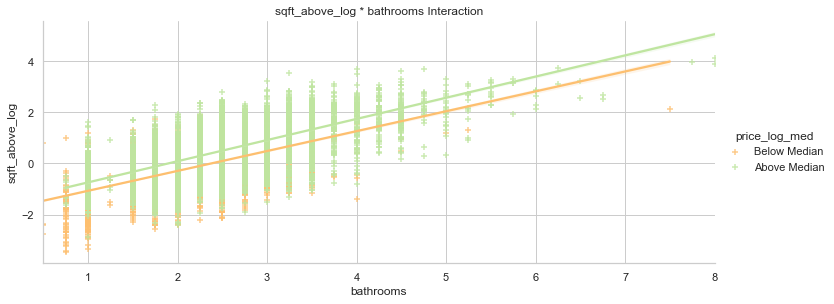

In [98]:
#plot sqft_above_log * bathrooms interaction
sns.lmplot(x = 'bathrooms', y = 'sqft_above_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_above_log * bathrooms Interaction')
plt.savefig('./Data & Figures/sqft_above_log * bathrooms')

**Observations:**
* 'sqft_above' is positively correlated with 'bathrooms' a house has, regardless of price.
* Both Below and Above Median groups behave the same.

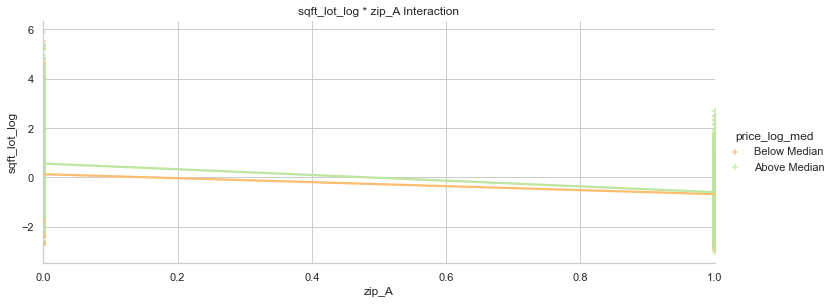

In [99]:
#plot sqft_lot_log * zip_A interaction
sns.lmplot(x = 'zip_A', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_lot_log * zip_A Interaction')
plt.savefig('./Data & Figures/sqft_lot_log * zip_A')

**Observations:**
* If a house in in 'zip_A', it is likely to have smaller 'sqft_lot' i.e 'zip_A' is negatively correlated with 'sqft_lot'.

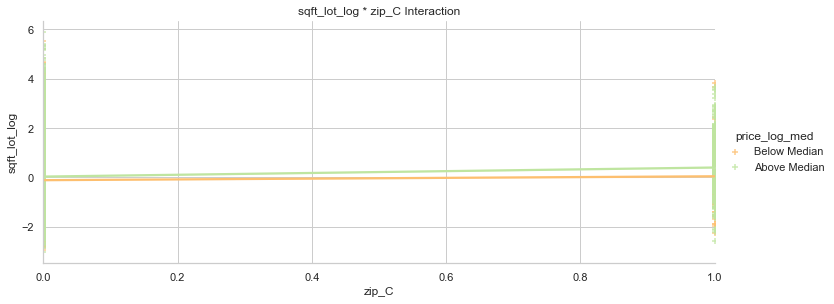

In [100]:
#plot sqft_lot_log * zip_C interaction
sns.lmplot(x = 'zip_C', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_lot_log * zip_C Interaction')
plt.savefig('./Data & Figures/sqft_lot_log * zip_C')

**Observations:**
* If a house in in 'zip_C', it is likely to have bigger 'sqft_lot' i.e. 'zip_C' is positively correlated to 'sqft_lot'.
* Opposite effect with 'zip_A'.

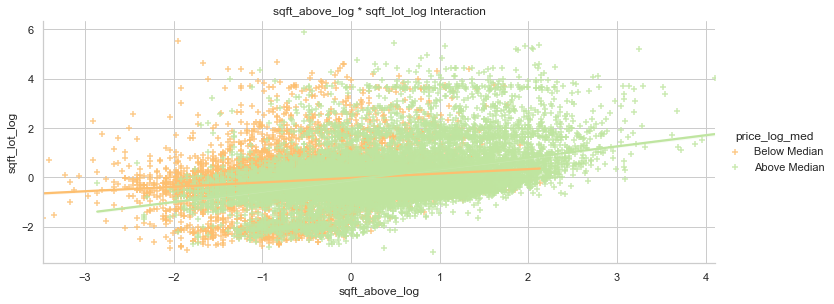

In [101]:
#plot sqft_above_log * sqft_lot_log interaction
sns.lmplot(x = 'sqft_above_log', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_above_log * sqft_lot_log Interaction')
plt.savefig('./Data & Figures/sqft_above_log * sqft_lot_log')

**Observations:**
* The bigger the 'sqft_above', the bigger the 'sqft_lot' i.e. 'sqft_above' is positively correlated with 'sqft_lot'.
* Both Below and Above Median groups behave the same, with Above having a bigger effect (steeper slope).

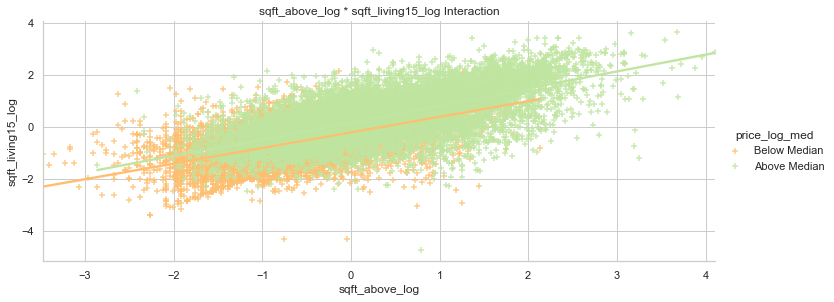

In [102]:
#plot sqft_above_log * sqft_living15_log interaction
sns.lmplot(x = 'sqft_above_log', y = 'sqft_living15_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_above_log * sqft_living15_log Interaction')
plt.savefig('./Data & Figures/sqft_above_log * sqft_living15_log')

**Observations:**
* The bigger the 'sqft_above', the bigger the 'sqft_living15' i.e. 'sqft_above' is positively correlated with 'sqft_living15'.

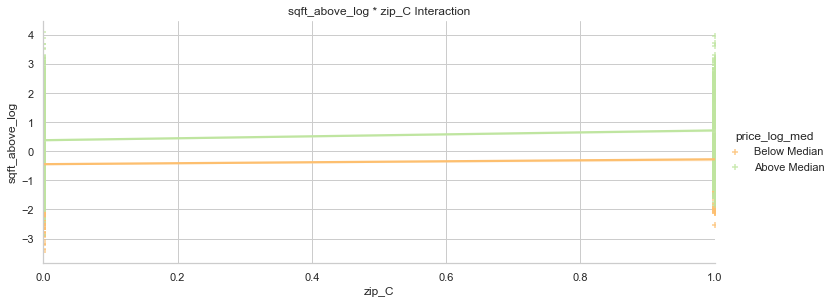

In [103]:
#plot sqft_above_log * zip_C interaction
sns.lmplot(x = 'zip_C', y = 'sqft_above_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_above_log * zip_C Interaction')
plt.savefig('./Data & Figures/sqft_above_log * zip_C')

**Observations:**
* If a house in in 'zip_C', it is likely to have slightly bigger 'sqft_above'.

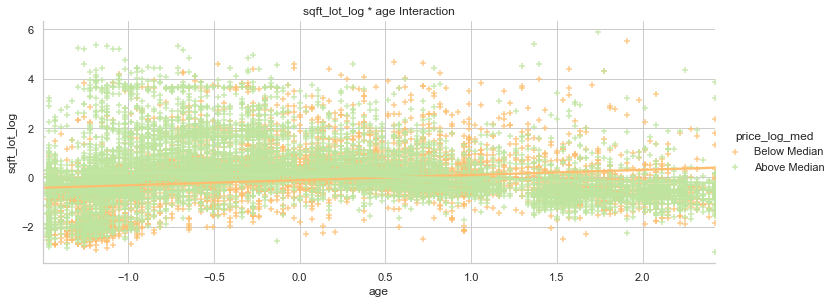

In [104]:
#plot sqft_lot_log * age interaction
sns.lmplot(x = 'age', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_lot_log * age Interaction')
plt.savefig('./Data & Figures/sqft_lot_log * age')

**Observations:**

* Newer houses have smaller 'sqft_lot'.

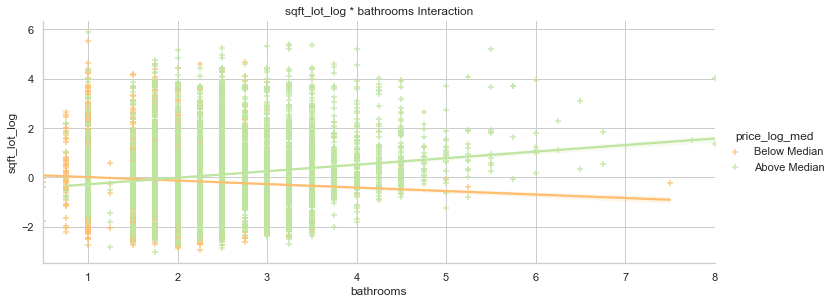

In [105]:
#plot sqft_lot_log * bathrooms interaction
sns.lmplot(x = 'bathrooms', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_lot_log * bathrooms Interaction')
plt.savefig('./Data & Figures/sqft_lot_log * bathrooms')

**Observations:**
* 'price' increases if 'sqft_lot' increases with 'bathrooms' increases.
* If 'sqft_lot' decreases and 'bathrooms' increases, 'price' will decrease.

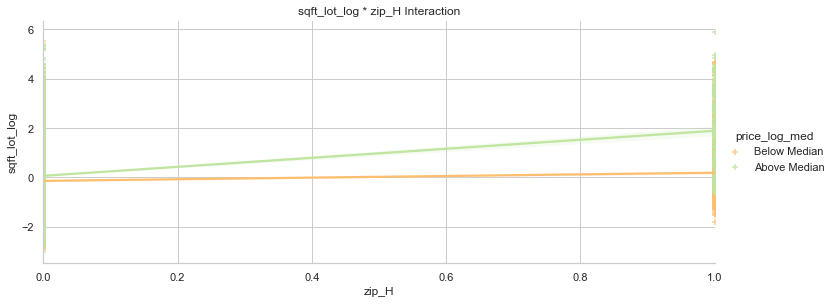

In [106]:
#plot sqft_lot_log * zip_H interaction
sns.lmplot(x = 'zip_H', y = 'sqft_lot_log', hue = 'price_log_med', 
           data = preprocessed_log_4, 
           fit_reg = True, palette = 'Spectral', markers = '+', size = 4, aspect = 2.5);
plt.title('sqft_lot_log * zip_H Interaction')
plt.savefig('./Data & Figures/sqft_lot_log * zip_H')

**Observations:**
* With the same 'sqft_lot', a house is worth more if it is in 'zip_H'.

In [107]:
#use 10-fold cross-validation to build a model using the above interaction
regression = LinearRegression()
crossvalidation = KFold(n_splits = 10, shuffle = True, random_state = 1)
X_interactions = X.copy()

X_interactions['sqft_living15_log * zip_C'] = X_interactions['sqft_living15_log'] * X_interactions['zip_C']
X_interactions['sqft_above_log * bathrooms'] = X_interactions['sqft_above_log'] * X_interactions['bathrooms']
X_interactions['sqft_lot_log * zip_A'] = X_interactions['sqft_lot_log'] * X_interactions['zip_A']
X_interactions['sqft_lot_log * zip_C'] = X_interactions['sqft_lot_log'] * X_interactions['zip_C']
X_interactions['sqft_above_log * sqft_lot_log'] = X_interactions['sqft_above_log'] * X_interactions['sqft_lot_log']
X_interactions['sqft_above_log * sqft_living15_log'] = X_interactions['sqft_above_log'] * X_interactions['sqft_living15_log']
X_interactions['sqft_above_log * zip_C'] = X_interactions['sqft_above_log'] * X_interactions['zip_C']
X_interactions['sqft_lot_log * age'] = X_interactions['sqft_lot_log'] * X_interactions['age']
X_interactions['sqft_lot_log * bathrooms'] = X_interactions['sqft_lot_log'] * X_interactions['bathrooms']
X_interactions['sqft_lot_log * zip_H'] = X_interactions['sqft_lot_log'] * X_interactions['zip_H']

interaction_model = np.mean(cross_val_score(regression, X_interactions, y, scoring = 'r2', cv = crossvalidation))

interaction_model

0.7757566230407426

In [108]:
#drop p-value > 0.05
#X_interactions.drop('zip_I', axis = 1, inplace = True)

In [109]:
#apply stepwise function
result_4 = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_4)

Add  sqft_living15_log              with p-value 0.0
Add  sqft_above_log * bathrooms     with p-value 0.0
Add  age                            with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_C                          with p-value 0.0
Add  zip_B                          with p-value 0.0
Add  zip_G                          with p-value 0.0
Add  sqft_above_log                 with p-value 5.7866e-218
Add  water_1.0                      with p-value 1.92999e-235
Add  zip_I                          with p-value 2.50533e-115
Add  sqft_lot_log * zip_A           with p-value 2.20984e-94
Add  zip_F                          with p-value 4.28382e-70
Add  bathrooms                      with p-value 1.56337e-68
Add  sqft_living15_log * zip_C      with p-value 6.35034e-56
Add  bedrooms                       with p-value 2.77561e-43
Add  cond_3.0                       with p-value 1.90243e-45
Add  cond_2.0            

## Build Model 4

In [110]:
#create model in OLS
X_int = sm.add_constant(X_interactions[result_4])
model_4 = sm.OLS(y, X_interactions[result_4]).fit()

model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.758
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              2576.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):                        0.00
Time:                        19:06:57   Log-Likelihood:                         -15203.
No. Observations:               21420   AIC:                                  3.046e+04
Df Residuals:                   21394   BIC:                                  3.066e+04
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
sqft_living15_log                 0.2196      0.006     38.243      0.000       0.208       0.231
sqft_above_log * bathrooms        0.0695      0.004     17.541      0.000       0.062       0.077
age                               0.0487      0.006      8.515      0.000       0.038       0.060
base_1.0                          0.4692      0.009     55.118      0.000       0.453       0.486
zip_A                             0.8803      0.013     69.064      0.000       0.855       0.905
zip_C                             0.7277      0.014     50.245      0.000       0.699       0.756
zip_B                             0.7202      0.012     57.624      0.000       0.696       0.745
zip_G                             0.6109      0.015     42.035      0.000       0.582       0.639
sqft_above_log                    0.4829      0.010     47.868      0.000       0.463       0.503
water_1.0                         1.2901      0.042     30.891      0.000       1.208       1.372
zip_I                             0.3358      0.022     15.370      0.000       0.293       0.379
sqft_lot_log * zip_A             -0.1702      0.009    -18.617      0.000      -0.188      -0.152
zip_F                            -0.3397      0.015    -23.305      0.000      -0.368      -0.311
bathrooms                        -0.0198      0.007     -2.848      0.004      -0.033      -0.006
sqft_living15_log * zip_C         0.1968      0.015     13.315      0.000       0.168       0.226
bedrooms                         -0.1833      0.004    -45.881      0.000      -0.191      -0.175
cond_3.0                         -0.2033      0.008    -24.486      0.000      -0.220      -0.187
cond_2.0                         -0.5153      0.039    -13.102      0.000      -0.592      -0.438
zip_E                             0.0387      0.016      2.407      0.016       0.007       0.070
sqft_lot_log * age               -0.0508      0.004    -12.339      0.000      -0.059      -0.043
reno_1.0                          0.2403      0.020     12.249      0.000       0.202       0.279
cond_5.0                          0.0816      0.014      5.886      0.000       0.054       0.109
sqft_lot_log * zip_H              0.0589      0.010      5.893      0.000       0.039       0.079
sqft_lot_log * zip_C              0.1534      0.017      9.145      0.000       0.120       0.186
sqft_above_log * zip_C           -0.0883      0.015     -6.086      0.000      -0.117      -0.060
sqft_above_log * sqft_lot_log    -0.0257      0.004     -7.040      0.000      -0.033      -0.019
==============================================================================
Omnibus:                      469.154   Durbin-Watson:         

## Test Model 4

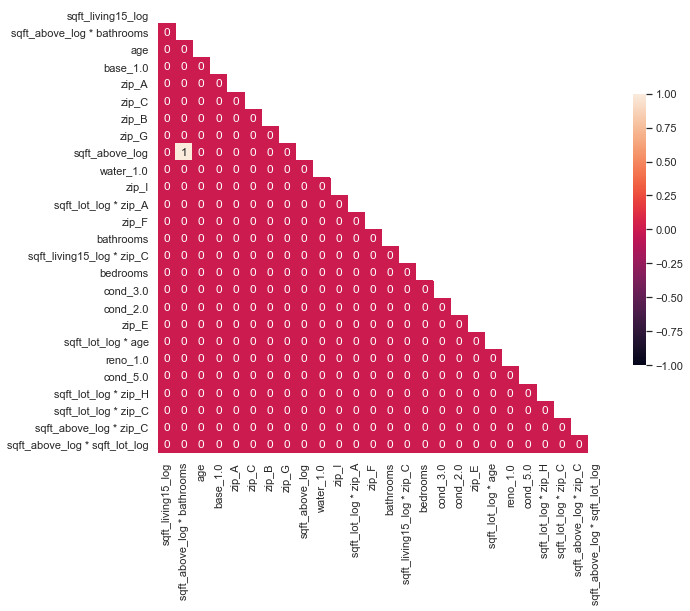

In [111]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_4].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_4].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)    
plt.savefig('./Data & Figures/model_4_multicollinarity_check')

In [112]:
#drop multicollinarity
X_interactions.drop(['sqft_above_log * bathrooms'], axis = 1, inplace = True)

In [113]:
#re-apply stepwise function
result_4 = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_4)

Add  bathrooms                      with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  sqft_living15_log * zip_C      with p-value 0.0
Add  sqft_living15_log              with p-value 0.0
Add  age                            with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  zip_A                          with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  zip_E                          with p-value 1.33724e-288
Add  base_1.0                       with p-value 9.09082e-278
Add  water_1.0                      with p-value 5.9412e-237
Add  zip_I                          with p-value 7.23864e-61
Add  bedrooms                       with p-value 1.94807e-56
Add  cond_3.0                       with p-value 1.14352e-43
Add  sqft_lot_log * zip_A           with p-value 9.438e-46
Add  sqft_lot_log * age             with p-value 5.06218e-44
Add  sqft_lot_log * zip_H          

## Re-build Model 4

In [114]:
X_int = sm.add_constant(X_interactions[result_4])
model_4 = sm.OLS(y, X_interactions[result_4]).fit()

model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.775
Model:                            OLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                              2725.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):                        0.00
Time:                        19:07:04   Log-Likelihood:                         -14429.
No. Observations:               21420   AIC:                                  2.891e+04
Df Residuals:                   21393   BIC:                                  2.913e+04
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
bathrooms                              0.1579      0.006     24.371      0.000       0.145       0.171
zip_F                                 -1.0750      0.013    -80.059      0.000      -1.101      -1.049
zip_H                                 -0.9201      0.015    -61.739      0.000      -0.949      -0.891
sqft_living15_log * zip_C              0.1793      0.014     12.886      0.000       0.152       0.207
sqft_living15_log                      0.2092      0.006     37.461      0.000       0.198       0.220
age                                    0.0855      0.006     15.518      0.000       0.075       0.096
sqft_above_log                         0.4805      0.006     78.385      0.000       0.468       0.493
zip_A                                  0.1576      0.011     13.863      0.000       0.135       0.180
zip_D                                 -0.8723      0.014    -63.711      0.000      -0.899      -0.845
zip_E                                 -0.6837      0.015    -45.553      0.000      -0.713      -0.654
base_1.0                               0.3419      0.008     41.290      0.000       0.326       0.358
water_1.0                              1.3552      0.040     33.604      0.000       1.276       1.434
zip_I                                 -0.3935      0.021    -18.999      0.000      -0.434      -0.353
bedrooms                              -0.0765      0.004    -20.304      0.000      -0.084      -0.069
cond_3.0                              -0.1078      0.008    -13.490      0.000      -0.123      -0.092
sqft_lot_log * zip_A                  -0.1510      0.010    -14.493      0.000      -0.171      -0.131
sqft_lot_log * age                    -0.0496      0.004    -12.061      0.000      -0.058      -0.042
sqft_lot_log * zip_H                   0.1064      0.011      9.829      0.000       0.085       0.128
sqft_lot_log * zip_C                   0.1505      0.016      9.158      0.000       0.118       0.183
cond_2.0                              -0.4149      0.038    -10.918      0.000      -0.489      -0.340
reno_1.0                               0.1890      0.019      9.989      0.000       0.152       0.226
cond_5.0                               0.1101      0.013      8.234      0.000       0.084       0.136
zip_G                                 -0.1200      0.013     -9.093      0.000      -0.146      -0.094
sqft_above_log * sqft_living15_log     0.0243      0.003      7.438      0.000       0.018       0.031
sqft_above_log * zip_C                -0.0596      0.014     -4.281      0.000      -0.087      -0.032
sqft_above_log * sqft_lot_log         -0.0208      0.004     -4.727      0.000      -0.029      -0.0

In [115]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_4], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_4])
yhat

array([-1.46770302, -0.96072832, -0.40856678, ..., -0.8565413 ,
       -0.50382536, -0.69479896])

In [116]:
#get intercept
linreg.intercept_

-0.05734626457506161

In [117]:
#get coefficients and sort them
coefficients_4 = dict(zip(X_interactions[result_4], list(linreg.coef_)))
dict(sorted(coefficients_4.items(), key = lambda item: item[1]))

{'zip_F': -1.068332809047243,
 'zip_H': -0.9134074507902594,
 'zip_D': -0.8666342488451666,
 'zip_E': -0.6770890149871139,
 'cond_2.0': -0.40948205277816135,
 'zip_I': -0.3870897433406454,
 'sqft_lot_log * zip_A': -0.15149756038180126,
 'zip_G': -0.11403750603033602,
 'cond_3.0': -0.10166145114186735,
 'bedrooms': -0.068525792375166,
 'sqft_above_log * zip_C': -0.05967863116617061,
 'sqft_lot_log * age': -0.0491100115440281,
 'sqft_above_log * sqft_lot_log': -0.020964691349108434,
 'sqft_lot_log * bathrooms': 0.010768470588700042,
 'sqft_above_log * sqft_living15_log': 0.02524256272594093,
 'age': 0.0879674238772622,
 'sqft_lot_log * zip_H': 0.10661498812776979,
 'cond_5.0': 0.11247625817318686,
 'sqft_lot_log * zip_C': 0.15171619829463537,
 'zip_A': 0.16334463765296303,
 'bathrooms': 0.1684633035368046,
 'sqft_living15_log * zip_C': 0.18013278573687372,
 'reno_1.0': 0.1857937249927731,
 'sqft_living15_log': 0.20920942895388936,
 'base_1.0': 0.3347752379437488,
 'sqft_above_log': 0.470

In [118]:
lists_4 = sorted(coefficients_4.items(), key = lambda item: item[1])
a, b = zip(*lists_4)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model 4 Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_4_waterfall.png')

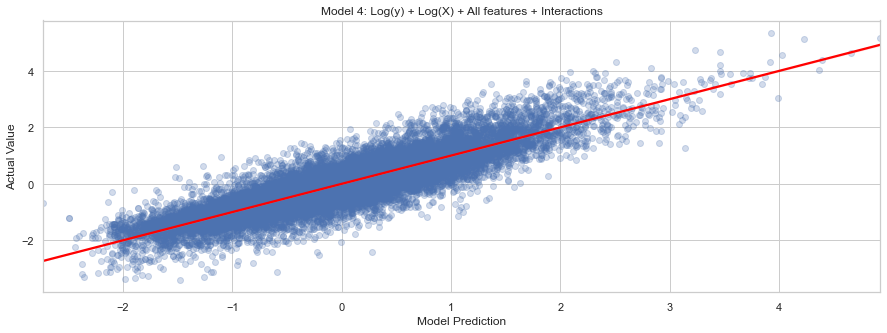

In [119]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, scatter_kws = {'color':'b','alpha': 0.25}, line_kws = {'color': 'red'})
plt.title('Model 4: Log(y) + Log(X) + All features + Interactions')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_4_scatterplot')

## Rank Features for Model 4

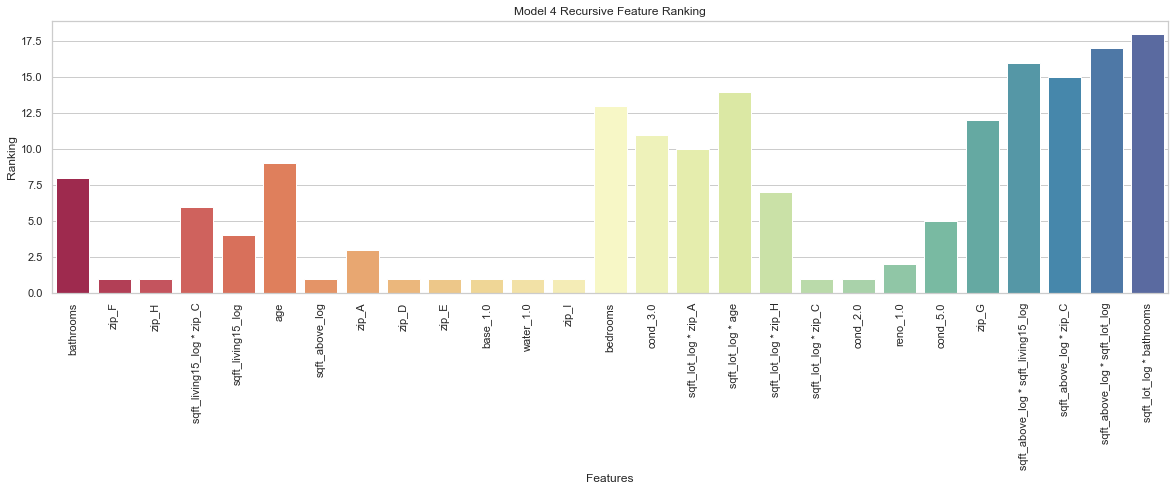

<Figure size 432x288 with 0 Axes>

In [120]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X_interactions[result_4], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X_interactions[result_4].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model 4 Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_4_recursive_features_elimination')

## Re-test Model 4

In [121]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_4].values, i) for i in range(X_interactions[result_4].shape[1])] 
list(zip(result_4, vif))

[('bathrooms', 20.253789437751706),
 ('zip_F', 1.338381455765879),
 ('zip_H', 1.4417801947330087),
 ('sqft_living15_log * zip_C', 3.1684112748905733),
 ('sqft_living15_log', 2.961299878526045),
 ('age', 2.8851482777124295),
 ('sqft_above_log', 3.5689080138509497),
 ('zip_A', 4.2193608665329645),
 ('zip_D', 1.3432600182075065),
 ('zip_E', 1.3754895651074055),
 ('base_1.0', 2.5605159377670588),
 ('water_1.0', 1.0528447117101818),
 ('zip_I', 1.1448060579035997),
 ('bedrooms', 16.442909445158485),
 ('cond_3.0', 3.9323597774739785),
 ('sqft_lot_log * zip_A', 3.3867038200059683),
 ('sqft_lot_log * age', 1.7025042897389282),
 ('sqft_lot_log * zip_H', 1.343989176776958),
 ('sqft_lot_log * zip_C', 1.53573850723634),
 ('cond_2.0', 1.0372044468585593),
 ('reno_1.0', 1.175003385986282),
 ('cond_5.0', 1.3379566367253175),
 ('zip_G', 1.4181510813513314),
 ('sqft_above_log * sqft_living15_log', 1.9079745835639186),
 ('sqft_above_log * zip_C', 2.694883300943856),
 ('sqft_above_log * sqft_lot_log', 2.4

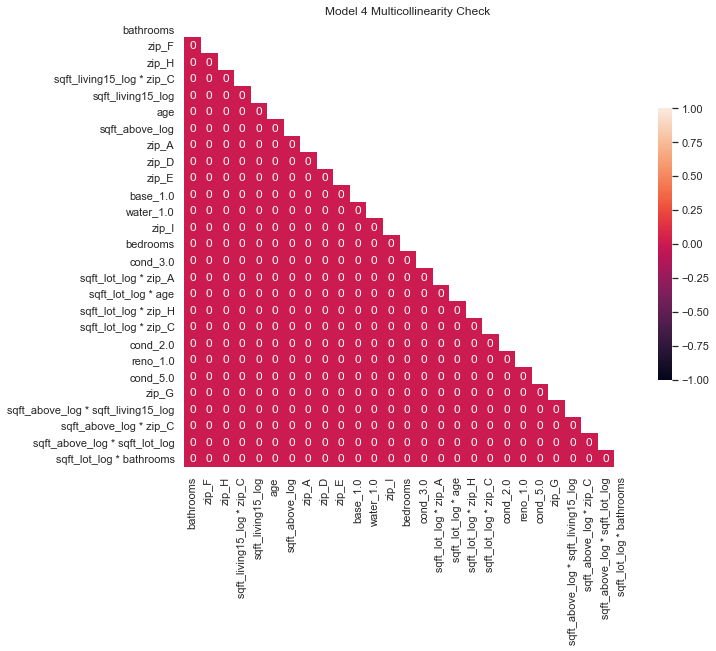

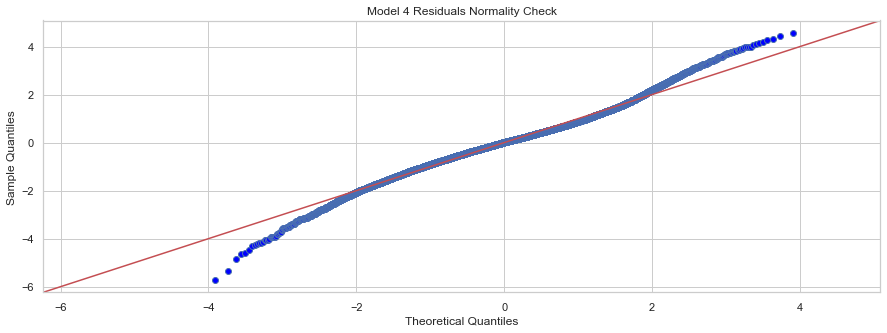

<Figure size 432x288 with 0 Axes>

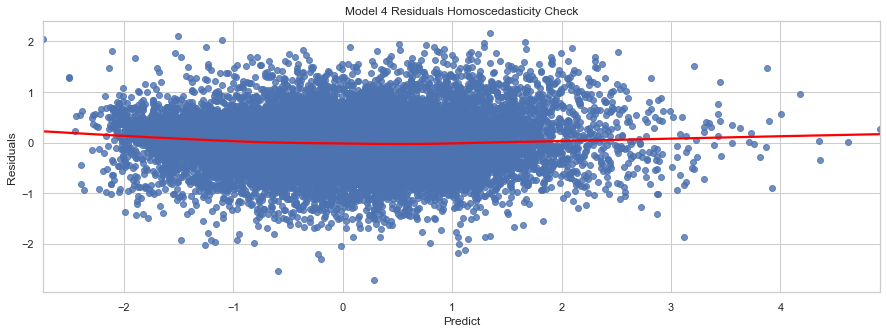

<Figure size 432x288 with 0 Axes>

In [122]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_4].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_4].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model 4 Multicollinearity Check')
plt.savefig('./Data & Figures/model_4_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_4.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model 4 Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_4_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_4.predict(), 
            y = model_4.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model 4 Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_4_homoscedasticity_regplot')

In [123]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_4.resid, model_4.model.exog)
list(zip(name, test))

[('F statistic', 1.0853420067045976), ('p-value', 1.1602055024648568e-05)]

CV: -0.4774018082422299


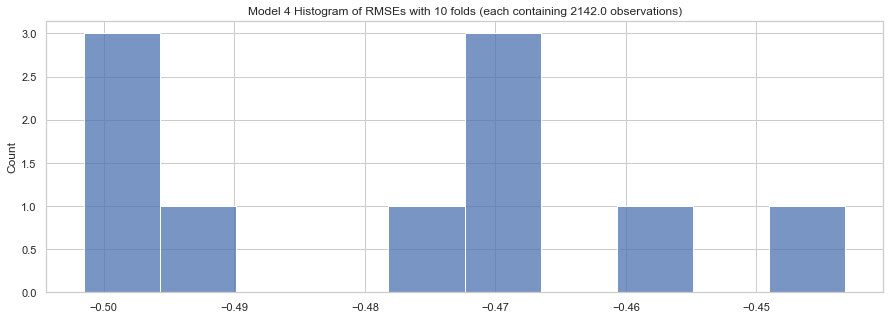

In [124]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X_interactions[result_4], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print('CV:', cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model 4 Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_4) / folds, 0)));
plt.savefig('./Data & Figures/model_4_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model 4

In [125]:
#split the data into training and test sets. Use the default split size
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_4], y, test_size = 0.20, random_state = 42)
print('Train Test Size:', len(X_train), len(y_train), len(X_test), len(y_test))

#import and initialize the linear regression model class
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

#calculate training and test MSE
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train Test Size: 17136 17136 4284 4284
Train RMSE: 0.4761399927371877
Test RMSE: 0.46824146602914


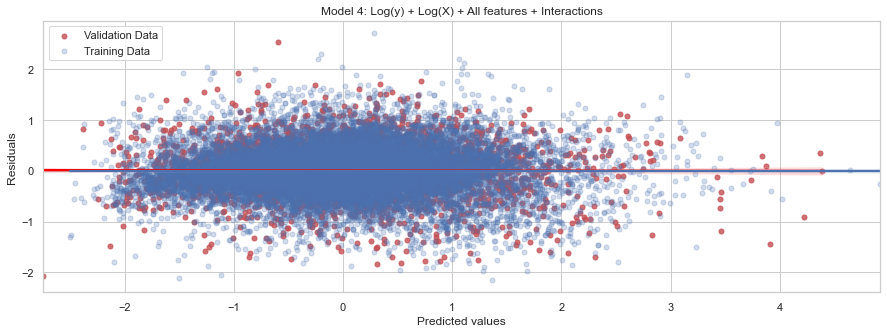

<Figure size 432x288 with 0 Axes>

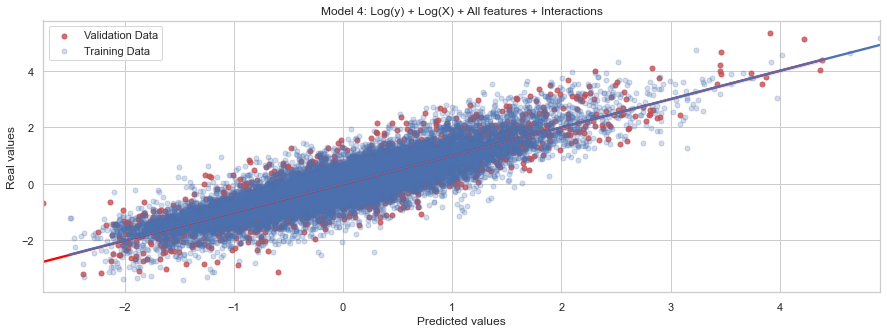

<Figure size 432x288 with 0 Axes>

In [126]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, fit_reg = True, label = 'Training Data')
plt.title('Model 4: Log(y) + Log(X) + All features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_4_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test,
            scatter_kws = {'s': 25}, line_kws = {'color': 'red'}, color = 'r', fit_reg = True, label = 'Validation Data')
sns.regplot(x = y_hat_train, y = y_train,
            scatter_kws = {'s': 25,'alpha':0.25}, fit_reg = True, label = 'Training Data')
plt.title('Model 4: Log(y) + Log(X) + All features + Interactions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_4_predictions_regplot')

In [127]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 78%'

In [128]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.259501528718508 
Train variance: 0.29513096220329893
Test bias: 0.26352861733459715 
Test variance: 0.28872272383578945


In [129]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_4.pkl','wb'))

In [130]:
#update summary
summary_table_2.loc[3] = ['Model 4', 'Log(y) + Log(X) + All features + Interactions', len(result_4) - 2, 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_2.head()

Model                                    Description   Num Features  \
0  Model 1      Log(y) + Log(X) + All features - location           13.0   
1  Model 2      Log(y) + Log(X) + All features + location           21.0   
2  Model 3           Log(y) + Log(X) + All features + RFE           10.0   
3  Model 4  Log(y) + Log(X) + All features + Interactions           25.0   

         r2   Accuracy  RMSE Train  RMSE Test    Bias Train  Bias Test  \
0  0.583683  59.656684    0.646611   0.639819  3.040415e-16   0.009110   
1  0.763374  77.249944    0.487979   0.480466  2.501445e-01   0.253404   
2  0.713161  72.401968    0.537166   0.529189  2.999619e-01   0.302846   
3  0.774831  78.392894    0.476140   0.468241  2.595015e-01   0.263529   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.578158       0.591311         -0.646711                 P   
1        0.319468       0.312714         -0.488725                 P   
2        0.368861       0.363598         -0.536978                 P   
3        0.295131       0.288723         -0.477402                 P   

  Normality Homoscedasticity  
0         P                P  
1         P                P  
2         P                P  
3         P                P

# MODEL 5: 
## POLYNOMIAL REGRESSION  ON MODEL 4

In [131]:
X_interactions.head(2)

sqft_above_log  sqft_lot_log  sqft_living15_log       age  bedrooms  \
15937       -1.443346      0.011001          -1.932101  0.955962         3   
20963       -1.390746     -2.297864          -0.818484 -1.357975         2   

       bathrooms  floors  water_1.0  base_1.0  reno_1.0  ...  zip_I  \
15937       1.00     1.0          0         1         0  ...      0   
20963       1.75     1.5          0         1         0  ...      0   

       sqft_living15_log * zip_C  sqft_lot_log * zip_A  sqft_lot_log * zip_C  \
15937                       -0.0                   0.0                   0.0   
20963                       -0.0                  -0.0                  -0.0   

       sqft_above_log * sqft_lot_log  sqft_above_log * sqft_living15_log  \
15937                      -0.015878                            2.788690   
20963                       3.195745                            1.138303   

       sqft_above_log * zip_C  sqft_lot_log * age  sqft_lot_log * bathrooms  \
15937                    -0.0            0.010516                  0.011001   
20963                    -0.0            3.120441                 -4.021261   

       sqft_lot_log * zip_H  
15937                   0.0  
20963                  -0.0  

[2 rows x 31 columns]

In [132]:
#transform non-normal features
#X_interactions['sqft_above_log_poly'] = X_interactions['sqft_above_log']**2
X_interactions['sqft_lot_log_poly'] = X_interactions['sqft_lot_log']**2
X_interactions['sqft_living15_log_poly'] = X_interactions['sqft_living15_log']**2

In [133]:
#drop old values
X_interactions.drop(['sqft_lot_log', 'sqft_living15_log'], axis = 1, inplace = True)

In [134]:
#review dataframe
X_interactions.head(2)

sqft_above_log       age  bedrooms  bathrooms  floors  water_1.0  \
15937       -1.443346  0.955962         3       1.00     1.0          0   
20963       -1.390746 -1.357975         2       1.75     1.5          0   

       base_1.0  reno_1.0  cond_2.0  cond_3.0  ...  sqft_lot_log * zip_A  \
15937         1         0         0         1  ...                   0.0   
20963         1         0         0         1  ...                  -0.0   

       sqft_lot_log * zip_C  sqft_above_log * sqft_lot_log  \
15937                   0.0                      -0.015878   
20963                  -0.0                       3.195745   

       sqft_above_log * sqft_living15_log  sqft_above_log * zip_C  \
15937                            2.788690                    -0.0   
20963                            1.138303                    -0.0   

       sqft_lot_log * age  sqft_lot_log * bathrooms  sqft_lot_log * zip_H  \
15937            0.010516                  0.011001                   0.0   
20963            3.120441                 -4.021261                  -0.0   

       sqft_lot_log_poly  sqft_living15_log_poly  
15937           0.000121                3.733015  
20963           5.280177                0.669915  

[2 rows x 31 columns]

In [135]:
#drop p-value > 0.05
#X_interactions.drop('sqft_lot_log * zip_C', axis = 1, inplace = True)

In [136]:
#apply stepwise function
result_5 = stepwise_selection(X_interactions, y, verbose=True)
print('Resulting Features:')
print(result_5)

Add  bathrooms                      with p-value 0.0
Add  zip_F                          with p-value 0.0
Add  zip_H                          with p-value 0.0
Add  sqft_living15_log * zip_C      with p-value 0.0
Add  sqft_above_log                 with p-value 0.0
Add  age                            with p-value 0.0
Add  zip_E                          with p-value 0.0
Add  base_1.0                       with p-value 0.0
Add  zip_D                          with p-value 0.0
Add  water_1.0                      with p-value 4.77513e-235
Add  zip_I                          with p-value 6.51443e-79
Add  bedrooms                       with p-value 1.38621e-76
Add  sqft_lot_log_poly              with p-value 2.60752e-43
Add  sqft_lot_log * age             with p-value 8.2872e-32
Add  zip_A                          with p-value 3.18416e-39
Add  cond_3.0                       with p-value 1.67462e-39
Add  cond_2.0                       with p-value 7.48142e-30
Add  sqft_above_log * zip_C        

## Build Model 5

In [137]:
#interecept is not included by default and should be added manually
X_in = X_interactions[result_5]
X_intercept = sm.add_constant(X_in) 

#estimation by ordinary least squares (OLS)
model_5 = sm.OLS(y, X_intercept).fit() 

#get summary
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     2343.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        19:07:34   Log-Likelihood:                -15083.
No. Observations:               21420   AIC:                         3.023e+04
Df Residuals:                   21390   BIC:                         3.047e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.0186      0.025     -0.739      0.460      -0.068       0.031
bathrooms                              0.1816      0.008     23.141      0.000       0.166       0.197
zip_F                                 -1.1117      0.014    -79.311      0.000      -1.139      -1.084
zip_H                                 -0.9465      0.016    -60.805      0.000      -0.977      -0.916
sqft_living15_log * zip_C              0.3658      0.014     26.437      0.000       0.339       0.393
sqft_above_log                         0.6155      0.007     87.391      0.000       0.602       0.629
age                                    0.0849      0.006     14.682      0.000       0.074       0.096
zip_E                                 -0.7519      0.016    -48.392      0.000      -0.782      -0.721
base_1.0                               0.4171      0.009     46.914      0.000       0.400       0.435
zip_D                                 -0.9029      0.014    -63.361      0.000      -0.931      -0.875
water_1.0                              1.4082      0.042     33.846      0.000       1.327       1.490
zip_I                                 -0.4191      0.022    -19.423      0.000      -0.461      -0.377
bedrooms                              -0.0791      0.005    -16.119      0.000      -0.089      -0.069
sqft_lot_log_poly                      0.0130      0.003      4.980      0.000       0.008       0.018
sqft_lot_log * age                    -0.0599      0.004    -13.320      0.000      -0.069      -0.051
zip_A                                  0.1212      0.012     10.187      0.000       0.098       0.145
cond_3.0                              -0.0972      0.009    -11.336      0.000      -0.114      -0.080
cond_2.0                              -0.4382      0.039    -11.153      0.000      -0.515      -0.361
sqft_above_log * zip_C                -0.1892      0.014    -13.327      0.000      -0.217      -0.161
sqft_lot_log * zip_C                   0.1370      0.017      8.026      0.000       0.104       0.170
sqft_lot_log * zip_H                   0.0904      0.012      7.815      0.000       0.068       0.113
sqft_above_log * sqft_living15_log     0.0590      0.005     11.185      0.000       0.049       0.069
sqft_lot_log * zip_A                  -0.1195      0.013     -9.321      0.000      -0.145      -0.094
sqft_above_log * sqft_lot_log         -0.0440      0.005     -9.536      0.000      -0.053      -0.035
reno_1.0                               0.1644      0.020      8.406      0.000       0.126       0.203
zip_G                                 -0.0967      0.014     -6.959      0.000      -0.124      -0.069
cond_5.0                               0.1021      0.014      7.383      0.000       0.075      

In [138]:
#create linear regression object
linreg = LinearRegression()

#fit model
linreg.fit(X_interactions[result_5], y)

#predict yhat using our model
yhat = linreg.predict(X_interactions[result_5])
yhat

array([-1.25120759, -0.89772544, -0.52402131, ..., -1.06117342,
       -0.84240485, -0.70250895])

In [139]:
#get intercept
linreg.intercept_

-0.018565568862994923

In [140]:
#get coefficients and sort them
coefficients_5 = dict(zip(X_interactions[result_5], list(linreg.coef_)))
dict(sorted(coefficients_5.items(), key = lambda item: item[1]))

{'zip_F': -1.111706728217806,
 'zip_H': -0.9464932530994181,
 'zip_D': -0.902924177168811,
 'zip_E': -0.7519472869850538,
 'cond_2.0': -0.43817515443893323,
 'zip_I': -0.4191134753023854,
 'sqft_above_log * zip_C': -0.1891852679291816,
 'sqft_lot_log * zip_A': -0.11953814279567695,
 'cond_3.0': -0.0971888850235451,
 'zip_G': -0.096701515052514,
 'bedrooms': -0.07907497768066797,
 'sqft_lot_log * age': -0.059872078064002826,
 'sqft_above_log * sqft_lot_log': -0.04395988361585141,
 'floors': -0.03173037334551171,
 'sqft_living15_log_poly': -0.018939578554460487,
 'sqft_lot_log * bathrooms': 0.009656852645983705,
 'sqft_lot_log_poly': 0.01300430040898831,
 'sqft_above_log * sqft_living15_log': 0.058960089928866866,
 'age': 0.08494808558223899,
 'sqft_lot_log * zip_H': 0.09039918321731488,
 'cond_5.0': 0.10207923243611058,
 'zip_A': 0.1212336082637426,
 'sqft_lot_log * zip_C': 0.13696718457947898,
 'reno_1.0': 0.16435615803904616,
 'bathrooms': 0.18155610737439784,
 'sqft_living15_log * zi

In [141]:
lists_5 = sorted(coefficients_5.items(), key = lambda item: item[1])
a, b = zip(*lists_5)
fig = go.Figure(go.Waterfall(x  = a, y = b, 
                             name = "coefficients"))
fig.update_layout(title = 'Model 5 Coefficients',
                  showlegend = True)
fig.update_xaxes(title_text = 'Features', tickangle = 90)
fig.update_yaxes(title_text = 'Coefficients')
fig.show()
#fig.write_image('./Data & Figures/model_5_waterfall.png')

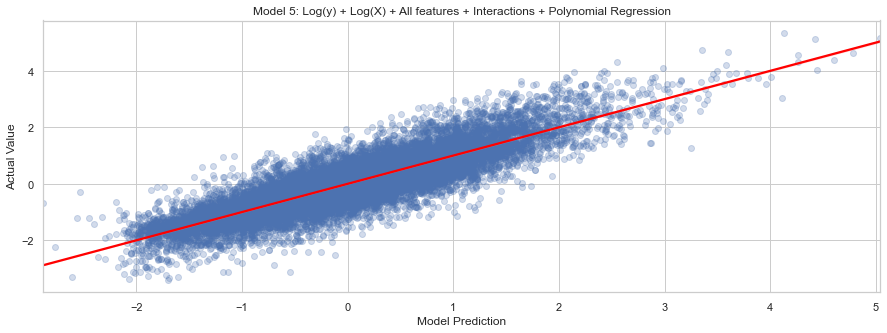

In [142]:
#plot y_hat
plt.figure(figsize = (15, 5))
sns.regplot(yhat, y, 
            line_kws = {'color': 'red'},
            scatter_kws = {'color':'b','alpha': 0.25},color='r')
plt.title('Model 5: Log(y) + Log(X) + All features + Interactions + Polynomial Regression')
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value');
plt.savefig('./Data & Figures/model_5_scatterplot')

## Rank Features for Model 5

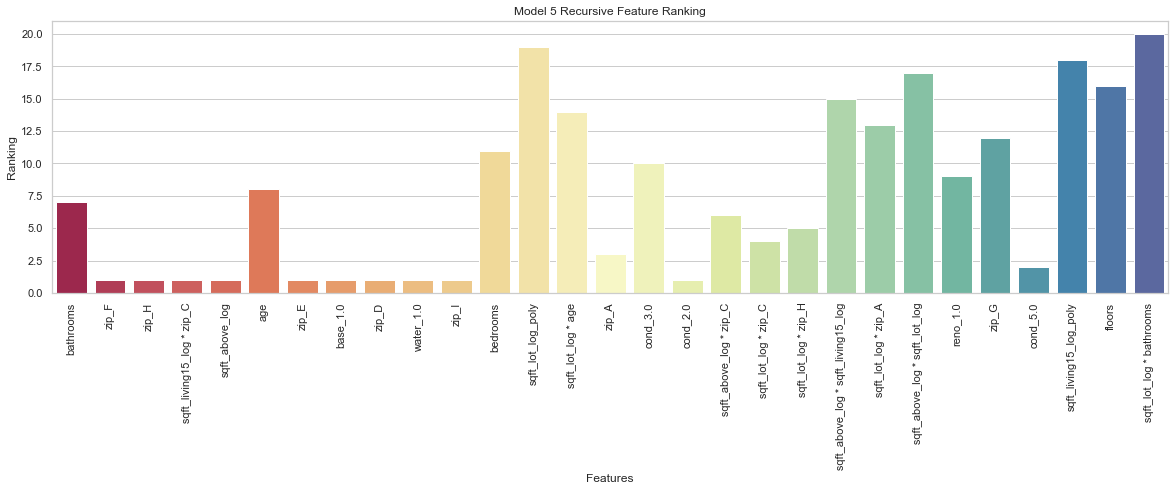

<Figure size 432x288 with 0 Axes>

In [143]:
linreg = LinearRegression()

#set number of features to be 10
selector = RFE(linreg, n_features_to_select = 10) 

#convert y to 1d np array to prevent DataConversionWarning
selector = selector.fit(X_interactions[result_5], y.values.ravel()) 
selector.support_

#plot features ranking
plt.figure(figsize = (20, 5))
sns.barplot(x = X_interactions[result_5].columns, y = selector.ranking_, palette = 'Spectral');
plt.title('Model 5 Recursive Feature Ranking')
plt.xlabel('Features')
plt.ylabel('Ranking')
plt.xticks(rotation = 90)
plt.show()
plt.savefig('./Data & Figures/model_5_recursive_features_elimination')

## Test Model 5

In [144]:
#recheck for multicollinearity
vif = [variance_inflation_factor(X_interactions[result_5].values, i) for i in range(X_interactions[result_5].shape[1])] 
list(zip(result_5, vif))

[('bathrooms', 24.62570134268719),
 ('zip_F', 1.344466206551682),
 ('zip_H', 1.4623846750520932),
 ('sqft_living15_log * zip_C', 2.9467392670598698),
 ('sqft_above_log', 2.438043638443783),
 ('age', 2.8953309779844667),
 ('zip_E', 1.3689599897851117),
 ('base_1.0', 2.7351369601072855),
 ('zip_D', 1.352499348839249),
 ('water_1.0', 1.0540899095718415),
 ('zip_I', 1.1627519766573258),
 ('bedrooms', 18.668658030947164),
 ('sqft_lot_log_poly', 3.8356372532792204),
 ('sqft_lot_log * age', 1.912163286670386),
 ('zip_A', 4.303568168256988),
 ('cond_3.0', 4.107357835128934),
 ('cond_2.0', 1.0414706066468924),
 ('sqft_above_log * zip_C', 2.635482357695586),
 ('sqft_lot_log * zip_C', 1.5544589393079826),
 ('sqft_lot_log * zip_H', 1.4435913770546553),
 ('sqft_above_log * sqft_living15_log', 4.65484384487107),
 ('sqft_lot_log * zip_A', 4.761798970000699),
 ('sqft_above_log * sqft_lot_log', 2.5662315670072386),
 ('reno_1.0', 1.1751550480691533),
 ('zip_G', 1.4661786525502232),
 ('cond_5.0', 1.34150

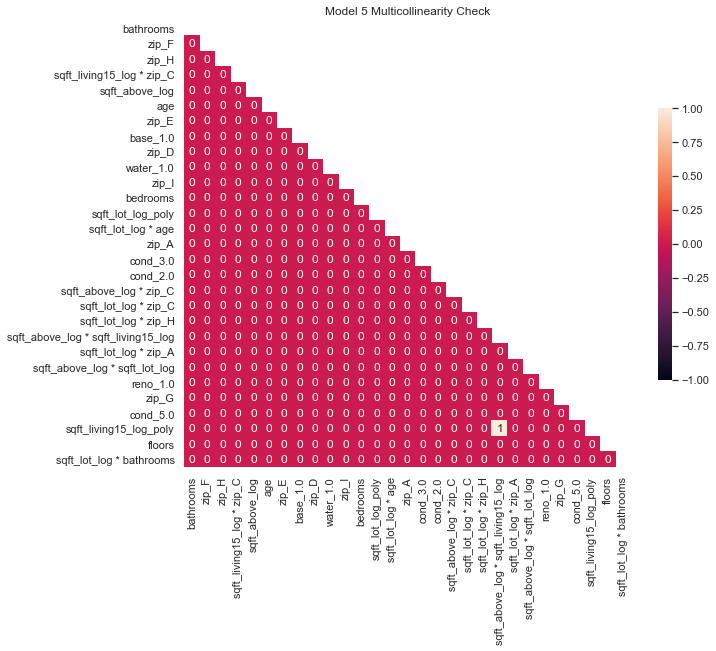

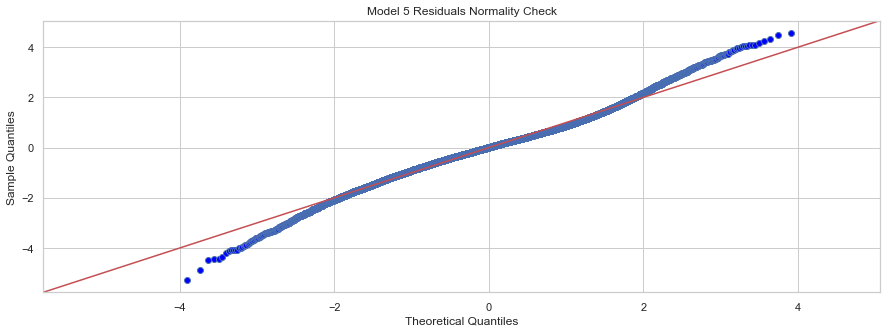

<Figure size 432x288 with 0 Axes>

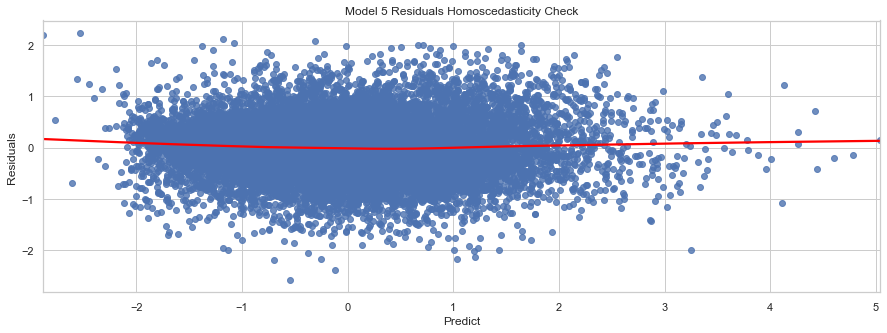

<Figure size 432x288 with 0 Axes>

In [145]:
#recheck for multicollinearity
mask = np.zeros_like(abs(X_interactions[result_5].corr()) > 0.75)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax = sns.heatmap(abs(X_interactions[result_5].corr()) > 0.75, 
                     annot = True, 
                     ax = ax, 
                     cbar_kws = {"shrink": .5}, 
                     mask = mask, 
                     vmax = 1,
                     vmin = -1,
                     square = True)  
    plt.title('Model 5 Multicollinearity Check')
plt.savefig('./Data & Figures/model_5_multicollinearity_check')

#recheck for normality
fig = sm.graphics.qqplot(model_5.resid, 
                         dist = stats.norm, 
                         line = '45', 
                         fit = True)
fig.set_size_inches(15, 5)
plt.title('Model 5 Residuals Normality Check')
plt.show()
plt.savefig('./Data & Figures/model_5_residuals_qqplot')

#recheck for homoscedasticity
plt.figure(figsize = (15, 5))
sns.regplot(x = model_5.predict(), 
            y = model_5.resid, 
            lowess = True, 
            line_kws = {'color': 'red'})
plt.title('Model 5 Residuals Homoscedasticity Check')
plt.xlabel('Predict')
plt.ylabel('Residuals')
plt.show()
plt.savefig('./Data & Figures/model_5_homoscedasticity_regplot')

In [146]:
#Goldfeld-Quandt test
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model_5.resid, model_5.model.exog)
list(zip(name, test))

[('F statistic', 1.0734441145974027), ('p-value', 0.00012529971583936505)]

-0.4922026179156365


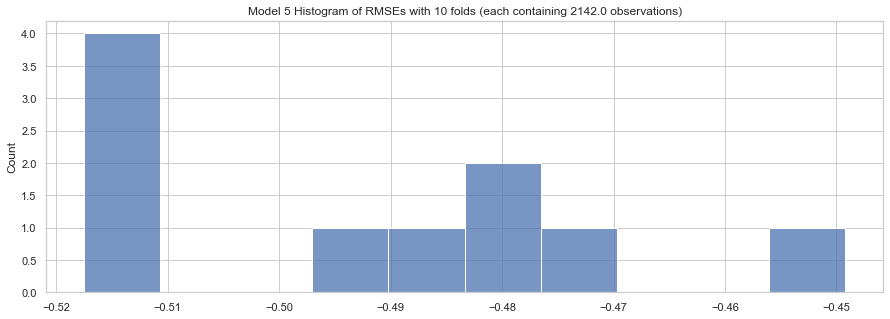

In [147]:
#cross-validation to check for overfitting
linreg = LinearRegression()

cv_result = cross_val_score(linreg, X_interactions[result_5], y, cv = 10, scoring = 'neg_root_mean_squared_error')
print(cv_result.mean())

#visualize the cv_result
folds = 10

plt.figure(figsize = (15, 5))
sns.histplot(cv_result, bins = 10);
plt.title('Model 5 Histogram of RMSEs with {} folds (each containing {} observations)'
          .format(folds, round(len(preprocessed_log_4) / folds, 0)));
plt.savefig('./Data & Figures/model_5_cv_result_histplot')

CV_result is the same as the model RMSE. We did not overfit the model.

## Validate Model 5

In [148]:
#split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X_interactions[result_5], y, test_size = 0.2, random_state = 42)
print(len(X_train), len(y_train), len(X_test), len(y_test))

linreg = LinearRegression()

#fit the model to train data
linreg.fit(X_train, y_train)

#calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

#calculate residuals (prediction - actual error)
train_residual = y_hat_train - y_train
test_residual = y_hat_test - y_test

train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(train_rmse)
print(test_rmse)

17136 17136 4284 4284
0.49073617766945715
0.48390453070721273


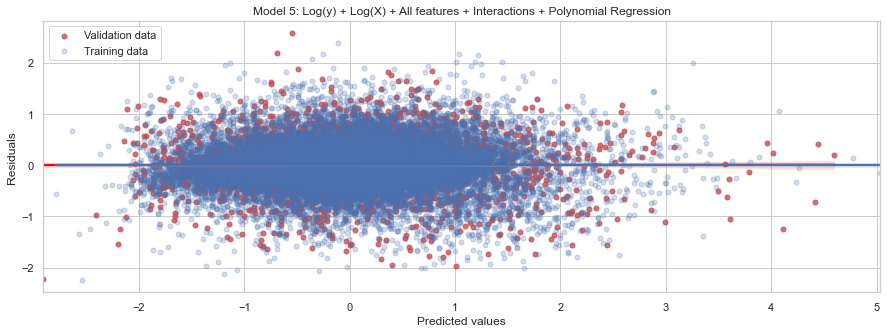

<Figure size 432x288 with 0 Axes>

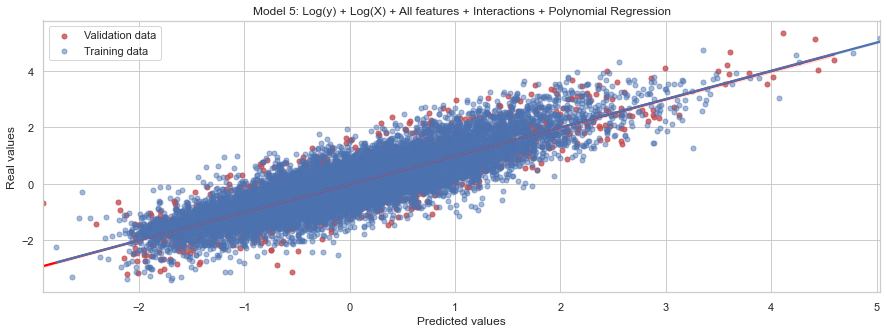

<Figure size 432x288 with 0 Axes>

In [149]:
#plot residuals: 
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_hat_test - y_test,
            scatter_kws = {'s': 25}, 
            line_kws = {'color': 'red'},
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_hat_train - y_train,
            scatter_kws = {'s': 25,'alpha': 0.25}, 
            fit_reg = True, label = 'Training data')

plt.title('Model 5: Log(y) + Log(X) + All features + Interactions + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = "upper left")
plt.show()
plt.savefig('./Data & Figures/model_5_residuals_regplot')

#plot predictions
plt.figure(figsize = (15, 5))
sns.regplot(x = y_hat_test, y = y_test, 
            line_kws = {'color': 'red'},
            scatter_kws = {'s': 25}, 
            color = 'r',
            fit_reg = True, label = 'Validation data')
sns.regplot(x = y_hat_train, y = y_train,  
                scatter_kws = {'s': 25,'alpha': 0.5}, fit_reg = True, label = 'Training data')

plt.title('Model 5: Log(y) + Log(X) + All features + Interactions + Polynomial Regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig('./Data & Figures/model_5_predictions_regplot')

In [150]:
#get accuracy percentage
accuracy = linreg.score(X_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 77%'

In [151]:
#get bias/variance tradeoff

#transform with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scale the train set
X_train_scaled = scaler.fit_transform(X_train)

#scale the test set
X_test_scaled = scaler.transform(X_test)

#training set predictions
lm_train_predictions = linreg.predict(X_train_scaled)

# Test set predictions 
lm_test_predictions = linreg.predict(X_test_scaled)

#bias and variance for training set 
b_train = bias(y_train, lm_train_predictions) 
v_train = variance(lm_train_predictions) 
print('Train bias: {} \nTrain variance: {}'.format(b_train, v_train))

#bias and variance for test set 
b_test = bias(y_test, lm_test_predictions) 
v_test = variance(lm_test_predictions) 
print('Test bias: {} \nTest variance: {}'.format(b_test, v_test))

Train bias: 0.28882957180857244 
Train variance: 0.3201348671073857
Test bias: 0.2935837874130953 
Test variance: 0.31360685553925366


In [152]:
#save model
tuple_objects = (linreg, X_train, y_train)
pickle.dump(tuple_objects, open('./Data & Figures/model_5.pkl','wb'))

In [153]:
summary_table_2.loc[4] = ['Model 5', 'Log(y) + Log(X) + All features + Interactions + Poly', len(result_5), 
                          r2_score(y, yhat), accuracy * 100, 
                          train_rmse, test_rmse,
                          b_train, b_test, v_train, v_test,
                          cv_result.mean(),
                          'P', 'P', 'P']
summary_table_2.head()

Model                                        Description   Num Features  \
0  Model 1          Log(y) + Log(X) + All features - location           13.0   
1  Model 2          Log(y) + Log(X) + All features + location           21.0   
2  Model 3               Log(y) + Log(X) + All features + RFE           10.0   
3  Model 4      Log(y) + Log(X) + All features + Interactions           25.0   
4  Model 5  Log(y) + Log(X) + All features + Interactions ...           29.0   

         r2   Accuracy  RMSE Train  RMSE Test    Bias Train  Bias Test  \
0  0.583683  59.656684    0.646611   0.639819  3.040415e-16   0.009110   
1  0.763374  77.249944    0.487979   0.480466  2.501445e-01   0.253404   
2  0.713161  72.401968    0.537166   0.529189  2.999619e-01   0.302846   
3  0.774831  78.392894    0.476140   0.468241  2.595015e-01   0.263529   
4  0.760567  76.923166    0.490736   0.483905  2.888296e-01   0.293584   

   Variance Train  Variance Test  Cross Validation Multicollinearity  \
0        0.578158       0.591311         -0.646711                 P   
1        0.319468       0.312714         -0.488725                 P   
2        0.368861       0.363598         -0.536978                 P   
3        0.295131       0.288723         -0.477402                 P   
4        0.320135       0.313607         -0.492203                 P   

  Normality Homoscedasticity  
0         P                P  
1         P                P  
2         P                P  
3         P                P  
4         P                P

In [154]:
#save
summary_table_2.to_csv('./Data & Figures/summary_table_2')

# BEST FIT MODEL: MODEL 4
# Best model in terms of r2, accuracy, RMSE

In [159]:
#load dataframe from Part A:
summary_table_1 = pd.read_csv('./Data & Figures/summary_table_1', index_col = 0)

#merge tables
models = pd.concat([summary_table_1, summary_table_2], ignore_index = True)
models

Model                                        Description  \
0    Model A                                       All features   
1    Model B                All features, outliers removed, RFE   
2    Model C               All features + Polynomial Regression   
3    Model D                              All features + Log(X)   
4   Model Ea                              Log(y) + All features   
5   Model Eb                        Log(y) + All features + VIF   
6   Model Fa               Log(y) + All features + Interactions   
7   Model Fb         Log(y) + All features + Interactions + VIF   
8    Model 1          Log(y) + Log(X) + All features - location   
9    Model 2          Log(y) + Log(X) + All features + location   
10   Model 3               Log(y) + Log(X) + All features + RFE   
11   Model 4      Log(y) + Log(X) + All features + Interactions   
12   Model 5  Log(y) + Log(X) + All features + Interactions ...   

     Num Features        r2   Accuracy  RMSE Train  RMSE Test    Bias Train  \
0            19.0  0.668177  66.236718    0.562527   0.628671  1.866439e-01   
1            10.0  0.642821  63.983660    0.535751   0.536075  1.696835e-01   
2            19.0  0.585625  56.964942    0.574945   0.585986 -1.227318e+00   
3            18.0  0.616832  59.185618    0.599998   0.691207  1.810976e-01   
4            22.0  0.761546  77.329107    0.490528   0.479629 -1.244998e-01   
5            19.0  0.760082  77.228842    0.492135   0.480689 -1.704098e-01   
6            22.0  0.772643  78.375267    0.478963   0.468432  1.622076e-01   
7            21.0  0.767947  77.884103    0.483760   0.473722  4.208151e-01   
8            13.0  0.583683  59.656684    0.646611   0.639819  3.040415e-16   
9            21.0  0.763374  77.249944    0.487979   0.480466  2.501445e-01   
10           10.0  0.713161  72.401968    0.537166   0.529189  2.999619e-01   
11           25.0  0.774831  78.392894    0.476140   0.468241  2.595015e-01   
12           29.0  0.760567  76.923166    0.490736   0.483905  2.888296e-01   

    Bias Test  Variance Train  Variance Test  Cross Validation  \
0    0.179878        0.210681       0.205261         -0.577799   
1    0.163239        0.208434       0.209862         -0.536612   
2   -1.227659        0.154362       0.155297         -0.579514   
3    0.173259        0.213091       0.207496         -0.618257   
4   -0.120081        0.300512       0.294564         -0.490940   
5   -0.166575        0.301239       0.294849         -0.492364   
6    0.166172        0.307562       0.301176         -0.479175   
7    0.424461        0.333529       0.326046         -0.479175   
8    0.009110        0.578158       0.591311         -0.646711   
9    0.253404        0.319468       0.312714         -0.488725   
10   0.302846        0.368861       0.363598         -0.536978   
11   0.263529        0.295131       0.288723         -0.477402   
12   0.293584        0.320135       0.313607         -0.492203   

   Multicollinearity Normality Homoscedasticity  
0                  P         F                F  
1                  P         F                F  
2                  P         F                F  
3                  P         F                F  
4                  P         P                P  
5                  P         P                P  
6                  P         P                P  
7                  P         P                P  
8                  P         P                P  
9                  P         P                P  
10                 P         P                P  
11                 P         P                P  
12                 P         P                P

In [160]:
#save
models.to_csv('./Data & Figures/models')

We can see that Model 4 has the highest r2 value and highest accuracy percentage. 

With the linear regression, we would interpret log transformed variables as a percentage change. (https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/)

* **Only the dependent/response variable y is log-transformed:** 

Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. 

* **Only independent/predictor variable(s) X is log-transformed:** 

Divide the coefficient by 100. This tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. 

* **Both dependent/response variable y and independent/predictor variable(s) X are log-transformed:** 

Interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable. 

# Model 4 Interpretation

## Q1: What are the most predictive features to predict the price of a home?

* We see that the presence of ‘waterfront’ is the most positively impactful feature for ‘price.’
* Location is also a positive factor for the value of a home: ‘zip_A’, ‘zip_C’, ‘zip_B’, ‘zip_G’, ‘zip_I’, ‘zip_E’ are good locations and ‘zip_F’ is negative.
* Other features that add value to a home are: ‘sqft_above’, ‘base_1.0’, ‘sqft_living15’, ‘reno_1.0’, ‘bathrooms’, ‘cond_5.0’, ‘age’.
* Interactions that have a positive impact on the price are: ‘sqft_log * zip_H’, ‘sqft_above * sqft_living15’, ‘sqft_lot * bathrooms’.
* Features that decrease the value of a home are: ‘bedrooms’, ‘cond_3.0’, ‘zip_F’, ‘cond_2.0’.
* Interactions that have a negative impact on the price are: ‘sqft_above * sqft_lot’, ‘sqft_lot * age’, ‘sqft_above * zip_C’, and ‘sqft_lot * zip_A’
* RFE ranks all zipcode area ‘zip_A’, ‘zip_C’, ‘zip_B’, ‘zip_G’, ‘zip_I’ and ‘sqft_above’, ‘base_1.0’, ‘water_1.0’, ‘cond_2.0’, and ‘reno_1.0’ as best predictive features.

# CONCLUSION

The variables that will affect the price change of each house in King County heavily are:

### Location
* When it comes to calculating a home’s value, location can be more important than even the size and condition of the house. This makes sense because when you buy a home, you are buying more than just a building. You are purchasing a lifestyle. You are purchasing a lifestyle and neighborhood that you are in will influence the lives of you and your family for as long as you live in there.
* If you have the mean to live anywhere, area C, located Eastside of King County, which includes Bellevue, Mercer Island, Newcastle, is the hottest place to be. One of the major reason for this is the presence of waterfront properties. Waterfront adds a significant value to the home.

### How much have homes sold for in the neighborhood?
* One of the best indicators of your home’s value is the sale prices of similar homes in your neighborhood that have sold recently.

### Usable living space
* The higher the square footage of sqft_living, sqft_lot, and sqft_above, the higher the price. But it is the livable square footage of sqft_above that actually determines the price of the house. This includes bedrooms, bathrooms, and floors. So the more beds and baths that your home offers, the more your home is generally worth.

### Age & Condition/ Grade
* The older the house, the less it is valued.
* The higher the condition, the higher the value of a house. Condition of at least 3 is recommended to get the value of the house up.
* The higher the grade, the higher the value of a house. Grade of at least 8 is recommended to get the value of the house up.
* Newer houses are graded higher due to better and more up to date material quality, architectural design, and construction. This includes critical parts of the house, like plumbing, electrical, the roof, and newer appliances.

### Renovation
* Renovation increases the value of the home.
* However, in term of age, we observe that only older houses tend to have renovation done. Although renovation increases the house’s price, older houses are still valued less than newer houses without renovation.
* In term of condition, when a house is old, even if it is in good and very good condition 4, and 5, it is still valued less than new houses with average condition of 3.
* In term of grade, newer houses are graded higher due to better and more up to date material quality, architectural design, and construction. This includes critical parts of the house, like plumbing, electrical, the roof, and newer appliances.
* Hence, although renovation can add values to older houses, the age of the house is a more impactful feature than any kind of adds-on.

# FUTURE WORK
1. Calculate value of the home in price per square foot instead of just price.
2. Research location in-depth such as:
* The quality of local schools
* Employment opportunities
* What are the neighbors like?
* Proximity to shopping, entertainment, and recreational centers
* Proximity to hospitals and other common services?
* Proximity to highways, utility lines, and public transit
* Proximity to the nearest major city?
3. How hot (or cold) is the area’s real estate market?
Because the number of other properties for sale in the area and the number of buyers in the market can impact the home value.
* In a buyer’s market: large inventory and low demand = favor the buyer.
* In a seller’s market: high demand and low inventory = favor the seller.
* In a balanced market: inventory matches demand.
4. When is the best time to buy or sell?